# Capstone Project

Soccer database of 2008-2016 European games with player and team data sourced from FIFA video game from 2008-2016.

https://www.kaggle.com/hugomathien/soccer

## Project Objective

The objective of this project is to perform multivariable classification on the outcome of soccer matches whether it is a win, lose or draw. The second part of this project is to build a regression model that can effectively predict the outcome of the match whether it is a win, lose or draw. The whole idea of this project is to try to mimic the bookmakers odds as close as possible.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.ElementTree as ET

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifier, RidgeClassifierCV
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

import pydotplus

from sklearn import tree

from IPython.display import Image 

## Loading Data and Checking Quality of Data (Nans, zeros etc.)

In [2]:
sqlite_sequence = pd.read_csv('../data/sqlite_sequence.csv')
player_attributes = pd.read_csv('../data/player_attributes.csv')
player = pd.read_csv('../data/player.csv')
match = pd.read_csv('../data/match.csv')
league = pd.read_csv('../data/league.csv')
country = pd.read_csv('../data/country.csv')
team = pd.read_csv('../data/team.csv')
team_attributes = pd.read_csv('../data/team_attributes.csv')

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [4]:
sqlite_sequence.head()

name     seq
0     Team  103916
1  Country   51958
2   League   51958
3    Match   51958
4   Player   11075

Sqlite_sequence table I suspect is simply the number of entries in each table in the database.

In [5]:
sqlite_sequence

name     seq
0               Team  103916
1            Country   51958
2             League   51958
3              Match   51958
4             Player   11075
5  Player_Attributes  183978
6    Team_Attributes    1458

In [6]:
team.head()

id  team_api_id  team_fifa_api_id     team_long_name team_short_name
0   1         9987             673.0           KRC Genk             GEN
1   2         9993             675.0       Beerschot AC             BAC
2   3        10000           15005.0   SV Zulte-Waregem             ZUL
3   4         9994            2007.0   Sporting Lokeren             LOK
4   5         9984            1750.0  KSV Cercle Brugge             CEB

In [7]:
team = team.set_index('id')

In [8]:
team.shape

(299, 4)

In [9]:
team.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299 entries, 1 to 51606
Data columns (total 4 columns):
team_api_id         299 non-null int64
team_fifa_api_id    288 non-null float64
team_long_name      299 non-null object
team_short_name     299 non-null object
dtypes: float64(1), int64(1), object(2)
memory usage: 11.7+ KB


In [10]:
team['team_long_name'].unique()

array(['KRC Genk', 'Beerschot AC', 'SV Zulte-Waregem', 'Sporting Lokeren',
       'KSV Cercle Brugge', 'RSC Anderlecht', 'KAA Gent', 'RAEC Mons',
       'FCV Dender EH', 'Standard de Liège', 'KV Mechelen',
       'Club Brugge KV', 'KSV Roeselare', 'KV Kortrijk', 'Tubize',
       'Royal Excel Mouscron', 'KVC Westerlo', 'Sporting Charleroi',
       'Sint-Truidense VV', 'Lierse SK', 'KAS Eupen',
       'Oud-Heverlee Leuven', 'Waasland-Beveren', 'KV Oostende',
       'Manchester United', 'Newcastle United', 'Arsenal',
       'West Bromwich Albion', 'Sunderland', 'Liverpool',
       'West Ham United', 'Wigan Athletic', 'Aston Villa',
       'Manchester City', 'Everton', 'Blackburn Rovers', 'Middlesbrough',
       'Tottenham Hotspur', 'Bolton Wanderers', 'Stoke City', 'Hull City',
       'Fulham', 'Chelsea', 'Portsmouth', 'Birmingham City',
       'Wolverhampton Wanderers', 'Burnley', 'Blackpool', 'Swansea City',
       'Queens Park Rangers', 'Norwich City', 'Southampton', 'Reading',
       

Team databse just has key parameters of names of teams and their short name as they appear on FIFA. On the surface, this table is not useful but maybe able to join this to other tables with the id key. Further, there are 11 null entries in the column team_fifa_api_id so keep that in mind if come back to this table.

In [11]:
team_attributes.columns

Index(['id', 'team_fifa_api_id', 'team_api_id', 'date', 'buildUpPlaySpeed',
       'buildUpPlaySpeedClass', 'buildUpPlayDribbling',
       'buildUpPlayDribblingClass', 'buildUpPlayPassing',
       'buildUpPlayPassingClass', 'buildUpPlayPositioningClass',
       'chanceCreationPassing', 'chanceCreationPassingClass',
       'chanceCreationCrossing', 'chanceCreationCrossingClass',
       'chanceCreationShooting', 'chanceCreationShootingClass',
       'chanceCreationPositioningClass', 'defencePressure',
       'defencePressureClass', 'defenceAggression', 'defenceAggressionClass',
       'defenceTeamWidth', 'defenceTeamWidthClass',
       'defenceDefenderLineClass'],
      dtype='object')

In [12]:
team_attributes.head()

id  team_fifa_api_id  team_api_id                 date  buildUpPlaySpeed  \
0   1               434         9930  2010-02-22 00:00:00                60   
1   2               434         9930  2014-09-19 00:00:00                52   
2   3               434         9930  2015-09-10 00:00:00                47   
3   4                77         8485  2010-02-22 00:00:00                70   
4   5                77         8485  2011-02-22 00:00:00                47   

  buildUpPlaySpeedClass  buildUpPlayDribbling buildUpPlayDribblingClass  \
0              Balanced                   NaN                    Little   
1              Balanced                  48.0                    Normal   
2              Balanced                  41.0                    Normal   
3                  Fast                   NaN                    Little   
4              Balanced                   NaN                    Little   

   buildUpPlayPassing buildUpPlayPassingClass buildUpPlayPositioningClass  \
0                  50                   Mixed                   Organised   
1                  56                   Mixed                   Organised   
2                  54                   Mixed                   Organised   
3                  70                    Long                   Organised   
4                  52                   Mixed                   Organised   

   chanceCreationPassing chanceCreationPassingClass  chanceCreationCrossing  \
0                     60                     Normal                      65   
1                     54                     Normal                      63   
2                     54                     Normal                      63   
3                     70                      Risky                      70   
4                     53                     Normal                      48   

  chanceCreationCrossingClass  chanceCreationShooting  \
0                      Normal                      55   
1                      Normal                      64   
2                      Normal                      64   
3                        Lots                      70   
4                      Normal                      52   

  chanceCreationShootingClass chanceCreationPositioningClass  defencePressure  \
0                      Normal                      Organised               50   
1                      Normal                      Organised               47   
2                      Normal                      Organised               47   
3                        Lots                      Organised               60   
4                      Normal                      Organised               47   

  defencePressureClass  defenceAggression defenceAggressionClass  \
0               Medium                 55                  Press   
1               Medium                 44                  Press   
2               Medium                 44                  Press   
3               Medium                 70                 Double   
4               Medium                 47                  Press   

   defenceTeamWidth defenceTeamWidthClass defenceDefenderLineClass  
0                45                Normal                    Cover  
1                54                Normal                    Cover  
2                54                Normal                    Cover  
3                70                  Wide                    Cover  
4                52                Normal                    Cover

In [13]:
team_attributes.shape

(1458, 25)

In [14]:
team_attributes = team_attributes.set_index('id')

In [15]:
team_attributes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458 entries, 1 to 1458
Data columns (total 24 columns):
team_fifa_api_id                  1458 non-null int64
team_api_id                       1458 non-null int64
date                              1458 non-null object
buildUpPlaySpeed                  1458 non-null int64
buildUpPlaySpeedClass             1458 non-null object
buildUpPlayDribbling              489 non-null float64
buildUpPlayDribblingClass         1458 non-null object
buildUpPlayPassing                1458 non-null int64
buildUpPlayPassingClass           1458 non-null object
buildUpPlayPositioningClass       1458 non-null object
chanceCreationPassing             1458 non-null int64
chanceCreationPassingClass        1458 non-null object
chanceCreationCrossing            1458 non-null int64
chanceCreationCrossingClass       1458 non-null object
chanceCreationShooting            1458 non-null int64
chanceCreationShootingClass       1458 non-null object
chanceCreationPositi

In [16]:
team_attributes[team_attributes['team_api_id']==10000]

team_fifa_api_id  team_api_id                 date  buildUpPlaySpeed  \
id                                                                           
1453             15005        10000  2010-02-22 00:00:00                65   
1454             15005        10000  2011-02-22 00:00:00                52   
1455             15005        10000  2012-02-22 00:00:00                54   
1456             15005        10000  2013-09-20 00:00:00                54   
1457             15005        10000  2014-09-19 00:00:00                54   
1458             15005        10000  2015-09-10 00:00:00                54   

     buildUpPlaySpeedClass  buildUpPlayDribbling buildUpPlayDribblingClass  \
id                                                                           
1453              Balanced                   NaN                    Little   
1454              Balanced                   NaN                    Little   
1455              Balanced                   NaN                    Little   
1456              Balanced                   NaN                    Little   
1457              Balanced                  42.0                    Normal   
1458              Balanced                  42.0                    Normal   

      buildUpPlayPassing buildUpPlayPassingClass buildUpPlayPositioningClass  \
id                                                                             
1453                  60                   Mixed                   Organised   
1454                  52                   Mixed                   Organised   
1455                  51                   Mixed                   Organised   
1456                  51                   Mixed                   Organised   
1457                  51                   Mixed                   Organised   
1458                  51                   Mixed                   Organised   

      chanceCreationPassing chanceCreationPassingClass  \
id                                                       
1453                     60                     Normal   
1454                     52                     Normal   
1455                     47                     Normal   
1456                     47                     Normal   
1457                     47                     Normal   
1458                     47                     Normal   

      chanceCreationCrossing chanceCreationCrossingClass  \
id                                                         
1453                      40                      Normal   
1454                      48                      Normal   
1455                      52                      Normal   
1456                      52                      Normal   
1457                      52                      Normal   
1458                      52                      Normal   

      chanceCreationShooting chanceCreationShootingClass  \
id                                                         
1453                      50                      Normal   
1454                      53                      Normal   
1455                      50                      Normal   
1456                      32                      Little   
1457                      32                      Little   
1458                      32                      Little   

     chanceCreationPositioningClass  defencePressure defencePressureClass  \
id                                                                          
1453                      Organised               70                 High   
1454                      Organised               46               Medium   
1455                      Organised               44               Medium   
1456                      Organised               44               Medium   
1457                      Organised               44               Medium   
1458                      Organised               44               Medium   

      defenceAggression defenceAggressionClass  defenceTeamWidth  \
id 

This data represents more granular data on each team. What is interesting is there is different data on the team based on the timestamp the data was collected. So with the above example for exampe, the team_api_id = 10000, hence will have to be careful if use this team attribute data at all. The only column NaNs is buildUpPlayDribbling so in the case I use this table, just ignore that column. 

In [17]:
player.head()

id  player_api_id         player_name  player_fifa_api_id  \
0   1         505942  Aaron Appindangoye              218353   
1   2         155782     Aaron Cresswell              189615   
2   3         162549         Aaron Doran              186170   
3   4          30572       Aaron Galindo              140161   
4   5          23780        Aaron Hughes               17725   

              birthday  height  weight  
0  1992-02-29 00:00:00  182.88     187  
1  1989-12-15 00:00:00  170.18     146  
2  1991-05-13 00:00:00  170.18     163  
3  1982-05-08 00:00:00  182.88     198  
4  1979-11-08 00:00:00  182.88     154

In [18]:
player.shape

(11060, 7)

In [19]:
player = player.set_index('id')

In [20]:
player.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11060 entries, 1 to 11075
Data columns (total 6 columns):
player_api_id         11060 non-null int64
player_name           11060 non-null object
player_fifa_api_id    11060 non-null int64
birthday              11060 non-null object
height                11060 non-null float64
weight                11060 non-null int64
dtypes: float64(1), int64(3), object(2)
memory usage: 604.8+ KB


In [21]:
player_attributes.head()

id  player_fifa_api_id  player_api_id                 date  overall_rating  \
0   1              218353         505942  2016-02-18 00:00:00            67.0   
1   2              218353         505942  2015-11-19 00:00:00            67.0   
2   3              218353         505942  2015-09-21 00:00:00            62.0   
3   4              218353         505942  2015-03-20 00:00:00            61.0   
4   5              218353         505942  2007-02-22 00:00:00            61.0   

   potential preferred_foot attacking_work_rate defensive_work_rate  crossing  \
0       71.0          right              medium              medium      49.0   
1       71.0          right              medium              medium      49.0   
2       66.0          right              medium              medium      49.0   
3       65.0          right              medium              medium      48.0   
4       65.0          right              medium              medium      48.0   

   finishing  heading_accuracy  short_passing  volleys  dribbling  curve  \
0       44.0              71.0           61.0     44.0       51.0   45.0   
1       44.0              71.0           61.0     44.0       51.0   45.0   
2       44.0              71.0           61.0     44.0       51.0   45.0   
3       43.0              70.0           60.0     43.0       50.0   44.0   
4       43.0              70.0           60.0     43.0       50.0   44.0   

   free_kick_accuracy  long_passing  ball_control  acceleration  sprint_speed  \
0                39.0          64.0          49.0          60.0          64.0   
1                39.0          64.0          49.0          60.0          64.0   
2                39.0          64.0          49.0          60.0          64.0   
3                38.0          63.0          48.0          60.0          64.0   
4                38.0          63.0          48.0          60.0          64.0   

   agility  reactions  balance  shot_power  jumping  stamina  strength  \
0     59.0       47.0     65.0        55.0     58.0     54.0      76.0   
1     59.0       47.0     65.0        55.0     58.0     54.0      76.0   
2     59.0       47.0     65.0        55.0     58.0     54.0      76.0   
3     59.0       46.0     65.0        54.0     58.0     54.0      76.0   
4     59.0       46.0     65.0        54.0     58.0     54.0      76.0   

   long_shots  aggression  interceptions  positioning  vision  penalties  \
0        35.0        71.0           70.0         45.0    54.0       48.0   
1        35.0        71.0           70.0         45.0    54.0       48.0   
2        35.0        63.0           41.0         45.0    54.0       48.0   
3        34.0        62.0           40.0         44.0    53.0       47.0   
4        34.0        62.0           40.0         44.0    53.0       47.0   

   marking  standing_tackle  sliding_tackle  gk_diving  gk_handling  \
0     65.0             69.0            69.0        6.0         11.0   
1     65.0             69.0            69.0        6.0         11.0   
2     65.0             66.0            69.0        6.0         11.0   
3     62.0             63.0            66.0        5.0         10.0   
4     62.0             63.0            66.0        5.0         10.0   

   gk_kicking  gk_positioning  gk_reflexes  
0        10.0             8.0          8.0  
1        10.0             8.0          8.0  
2        10.0             8.0          8.0  
3         9.0             7.0          7.0  
4         9.0             7.0          7.0

In [22]:
player_attributes = player_attributes.set_index('id')

In [23]:
player_attributes.shape

(183978, 41)

In [24]:
player_attributes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183978 entries, 1 to 183978
Data columns (total 41 columns):
player_fifa_api_id     183978 non-null int64
player_api_id          183978 non-null int64
date                   183978 non-null object
overall_rating         183142 non-null float64
potential              183142 non-null float64
preferred_foot         183142 non-null object
attacking_work_rate    180748 non-null object
defensive_work_rate    183142 non-null object
crossing               183142 non-null float64
finishing              183142 non-null float64
heading_accuracy       183142 non-null float64
short_passing          183142 non-null float64
volleys                181265 non-null float64
dribbling              183142 non-null float64
curve                  181265 non-null float64
free_kick_accuracy     183142 non-null float64
long_passing           183142 non-null float64
ball_control           183142 non-null float64
acceleration           183142 non-null float64
spri

In [25]:
player_attributes.isna().sum()

player_fifa_api_id        0
player_api_id             0
date                      0
overall_rating          836
potential               836
preferred_foot          836
attacking_work_rate    3230
defensive_work_rate     836
crossing                836
finishing               836
heading_accuracy        836
short_passing           836
volleys                2713
dribbling               836
curve                  2713
free_kick_accuracy      836
long_passing            836
ball_control            836
acceleration            836
sprint_speed            836
agility                2713
reactions               836
balance                2713
shot_power              836
jumping                2713
stamina                 836
strength                836
long_shots              836
aggression              836
interceptions           836
positioning             836
vision                 2713
penalties               836
marking                 836
standing_tackle         836
sliding_tackle      

This data is similar to the team dataset but instead it is of players. The missing data is minimal out of the full data we have available. Again, at this point, not the primary objective of my analysis but would like to try to do something with this data at a later point in time. Most likely generating some sort of overall rating from the other features if I do anything with this data.

In [26]:
country.head()

id     name
0      1  Belgium
1   1729  England
2   4769   France
3   7809  Germany
4  10257    Italy

In [27]:
country

id         name
0       1      Belgium
1    1729      England
2    4769       France
3    7809      Germany
4   10257        Italy
5   13274  Netherlands
6   15722       Poland
7   17642     Portugal
8   19694     Scotland
9   21518        Spain
10  24558  Switzerland

In [28]:
country = country.set_index('id')

In [29]:
country.shape

(11, 1)

Country table is very, very straight forward. Will be used later on.

In [30]:
league.head()

id  country_id                    name
0      1           1  Belgium Jupiler League
1   1729        1729  England Premier League
2   4769        4769          France Ligue 1
3   7809        7809   Germany 1. Bundesliga
4  10257       10257           Italy Serie A

In [31]:
league

id  country_id                      name
0       1           1    Belgium Jupiler League
1    1729        1729    England Premier League
2    4769        4769            France Ligue 1
3    7809        7809     Germany 1. Bundesliga
4   10257       10257             Italy Serie A
5   13274       13274    Netherlands Eredivisie
6   15722       15722        Poland Ekstraklasa
7   17642       17642  Portugal Liga ZON Sagres
8   19694       19694   Scotland Premier League
9   21518       21518           Spain LIGA BBVA
10  24558       24558  Switzerland Super League

Again, straight forward. Will be used later on.

In [32]:
match.head()

id  country_id  league_id     season  stage                 date  \
0   1           1          1  2008/2009      1  2008-08-17 00:00:00   
1   2           1          1  2008/2009      1  2008-08-16 00:00:00   
2   3           1          1  2008/2009      1  2008-08-16 00:00:00   
3   4           1          1  2008/2009      1  2008-08-17 00:00:00   
4   5           1          1  2008/2009      1  2008-08-16 00:00:00   

   match_api_id  home_team_api_id  away_team_api_id  home_team_goal  \
0        492473              9987              9993               1   
1        492474             10000              9994               0   
2        492475              9984              8635               0   
3        492476              9991              9998               5   
4        492477              7947              9985               1   

   away_team_goal  home_player_X1  home_player_X2  home_player_X3  \
0               1             NaN             NaN             NaN   
1               0             NaN             NaN             NaN   
2               3             NaN             NaN             NaN   
3               0             NaN             NaN             NaN   
4               3             NaN             NaN             NaN   

   home_player_X4  home_player_X5  home_player_X6  home_player_X7  \
0             NaN             NaN             NaN             NaN   
1             NaN             NaN             NaN             NaN   
2             NaN             NaN             NaN             NaN   
3             NaN             NaN             NaN             NaN   
4             NaN             NaN             NaN             NaN   

   home_player_X8  home_player_X9  home_player_X10  home_player_X11  \
0             NaN             NaN              NaN              NaN   
1             NaN             NaN              NaN              NaN   
2             NaN             NaN              NaN              NaN   
3             NaN             NaN              NaN              NaN   
4             NaN             NaN              NaN              NaN   

   away_player_X1  away_player_X2  away_player_X3  away_player_X4  \
0             NaN             NaN             NaN             NaN   
1             NaN             NaN             NaN             NaN   
2             NaN             NaN             NaN             NaN   
3             NaN             NaN             NaN             NaN   
4             NaN             NaN             NaN             NaN   

   away_player_X5  away_player_X6  away_player_X7  away_player_X8  \
0             NaN             NaN             NaN             NaN   
1             NaN             NaN             NaN             NaN   
2             NaN             NaN             NaN             NaN   
3             NaN             NaN             NaN             NaN   
4             NaN             NaN             NaN             NaN   

   away_player_X9  away_player_X10  away_player_X11  home_player_Y1  \
0             NaN              NaN              NaN             NaN   
1             NaN              NaN              NaN             NaN   
2             NaN              NaN              NaN             NaN   
3             NaN              NaN              NaN             NaN   
4             NaN              NaN              NaN             NaN   

   home_player_Y2  home_player_Y3  home_player_Y4  home_player_Y5  \
0             NaN             NaN             NaN             NaN   
1             NaN             NaN             NaN             NaN   
2             NaN             NaN             NaN             NaN   
3             NaN             NaN             NaN             NaN   
4             NaN             NaN             NaN             NaN   

   home_player_Y6  home_player_Y7  home_player_Y8  home_player_Y9  \
0             NaN             NaN             NaN             NaN   
1             NaN             NaN             NaN             NaN   
2            

In [33]:
#match = match.set_index('id')

In [34]:
match.head()

id  country_id  league_id     season  stage                 date  \
0   1           1          1  2008/2009      1  2008-08-17 00:00:00   
1   2           1          1  2008/2009      1  2008-08-16 00:00:00   
2   3           1          1  2008/2009      1  2008-08-16 00:00:00   
3   4           1          1  2008/2009      1  2008-08-17 00:00:00   
4   5           1          1  2008/2009      1  2008-08-16 00:00:00   

   match_api_id  home_team_api_id  away_team_api_id  home_team_goal  \
0        492473              9987              9993               1   
1        492474             10000              9994               0   
2        492475              9984              8635               0   
3        492476              9991              9998               5   
4        492477              7947              9985               1   

   away_team_goal  home_player_X1  home_player_X2  home_player_X3  \
0               1             NaN             NaN             NaN   
1               0             NaN             NaN             NaN   
2               3             NaN             NaN             NaN   
3               0             NaN             NaN             NaN   
4               3             NaN             NaN             NaN   

   home_player_X4  home_player_X5  home_player_X6  home_player_X7  \
0             NaN             NaN             NaN             NaN   
1             NaN             NaN             NaN             NaN   
2             NaN             NaN             NaN             NaN   
3             NaN             NaN             NaN             NaN   
4             NaN             NaN             NaN             NaN   

   home_player_X8  home_player_X9  home_player_X10  home_player_X11  \
0             NaN             NaN              NaN              NaN   
1             NaN             NaN              NaN              NaN   
2             NaN             NaN              NaN              NaN   
3             NaN             NaN              NaN              NaN   
4             NaN             NaN              NaN              NaN   

   away_player_X1  away_player_X2  away_player_X3  away_player_X4  \
0             NaN             NaN             NaN             NaN   
1             NaN             NaN             NaN             NaN   
2             NaN             NaN             NaN             NaN   
3             NaN             NaN             NaN             NaN   
4             NaN             NaN             NaN             NaN   

   away_player_X5  away_player_X6  away_player_X7  away_player_X8  \
0             NaN             NaN             NaN             NaN   
1             NaN             NaN             NaN             NaN   
2             NaN             NaN             NaN             NaN   
3             NaN             NaN             NaN             NaN   
4             NaN             NaN             NaN             NaN   

   away_player_X9  away_player_X10  away_player_X11  home_player_Y1  \
0             NaN              NaN              NaN             NaN   
1             NaN              NaN              NaN             NaN   
2             NaN              NaN              NaN             NaN   
3             NaN              NaN              NaN             NaN   
4             NaN              NaN              NaN             NaN   

   home_player_Y2  home_player_Y3  home_player_Y4  home_player_Y5  \
0             NaN             NaN             NaN             NaN   
1             NaN             NaN             NaN             NaN   
2             NaN             NaN             NaN             NaN   
3             NaN             NaN             NaN             NaN   
4             NaN             NaN             NaN             NaN   

   home_player_Y6  home_player_Y7  home_player_Y8  home_player_Y9  \
0             NaN             NaN             NaN             NaN   
1             NaN             NaN             NaN             NaN   
2            

In [35]:
match.info(25000)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 115 columns):
id                  int64
country_id          int64
league_id           int64
season              object
stage               int64
date                object
match_api_id        int64
home_team_api_id    int64
away_team_api_id    int64
home_team_goal      int64
away_team_goal      int64
home_player_X1      float64
home_player_X2      float64
home_player_X3      float64
home_player_X4      float64
home_player_X5      float64
home_player_X6      float64
home_player_X7      float64
home_player_X8      float64
home_player_X9      float64
home_player_X10     float64
home_player_X11     float64
away_player_X1      float64
away_player_X2      float64
away_player_X3      float64
away_player_X4      float64
away_player_X5      float64
away_player_X6      float64
away_player_X7      float64
away_player_X8      float64
away_player_X9      float64
away_player_X10     float64
away_player_X1

In [36]:
match.isna().sum()

id                      0
country_id              0
league_id               0
season                  0
stage                   0
date                    0
match_api_id            0
home_team_api_id        0
away_team_api_id        0
home_team_goal          0
away_team_goal          0
home_player_X1       1821
home_player_X2       1821
home_player_X3       1832
home_player_X4       1832
home_player_X5       1832
home_player_X6       1832
home_player_X7       1832
home_player_X8       1832
home_player_X9       1832
home_player_X10      1832
home_player_X11      1832
away_player_X1       1832
away_player_X2       1832
away_player_X3       1832
away_player_X4       1832
away_player_X5       1832
away_player_X6       1832
away_player_X7       1832
away_player_X8       1832
away_player_X9       1833
away_player_X10      1833
away_player_X11      1839
home_player_Y1       1821
home_player_Y2       1821
home_player_Y3       1832
home_player_Y4       1832
home_player_Y5       1832
home_player_

In [37]:
match.shape

(25979, 115)

In [38]:
match.sample(1000).head(20)

id  country_id  league_id     season  stage                 date  \
13948  13949       13274      13274  2010/2011     16  2010-11-26 00:00:00   
20066  20067       19694      19694  2009/2010     31  2010-03-27 00:00:00   
2363    2364        1729       1729  2009/2010     32  2010-03-27 00:00:00   
20047  20048       19694      19694  2009/2010     29  2010-03-20 00:00:00   
12060  12061       10257      10257  2012/2013     37  2013-05-12 00:00:00   
9721    9722        7809       7809  2014/2015     17  2014-12-21 00:00:00   
1381    1382           1          1  2014/2015     24  2015-02-01 00:00:00   
15070  15071       13274      13274  2013/2014      5  2013-09-01 00:00:00   
24874  24875       24558      24558  2009/2010     34  2010-05-06 00:00:00   
24224  24225       21518      21518  2015/2016     13  2015-11-28 00:00:00   
16608  16609       15722      15722  2011/2012     28  2012-04-30 00:00:00   
18201  18202       17642      17642  2010/2011     19  2011-02-13 00:00:00   
4248    4249        1729       1729  2014/2015     31  2015-04-04 00:00:00   
2548    2549        1729       1729  2010/2011     15  2010-11-27 00:00:00   
13111  13112       10257      10257  2015/2016     29  2016-03-11 00:00:00   
22192  22193       21518      21518  2009/2010     36  2010-05-04 00:00:00   
16164  16165       15722      15722  2009/2010      5  2009-08-30 00:00:00   
19218  19219       17642      17642  2014/2015     23  2015-03-02 00:00:00   
6273    6274        4769       4769  2011/2012      8  2011-09-24 00:00:00   
21266  21267       19694      19694  2014/2015      6  2014-09-13 00:00:00   

       match_api_id  home_team_api_id  away_team_api_id  home_team_goal  \
13948        836427              9761              8640               4   
20066        659045              9860              8548               1   
2363         659134              8602              8668               0   
20047        659032              8429              8596               2   
12060       1287333              8564              8686               0   
9721        1732870              8177              8226               0   
1381        1718006              9989              9985               2   
15070       1473065             10235              9803               4   
24874        768501              6493             10199               0   
24224       2030210              9906              8558               1   
16608       1030985             10265              2186               1   
18201        859790              9772              7844               3   
4248        1724282              9825              8650               4   
2548         839954             10260              8655               7   
13111       2060462              9885              7943               1   
22192        685173             10267              9868               3   
16164        673733              2182              8569               2   
19218       1750675              9807              6403               0   
6273        1019467             10249              9847               0   
21266       1726050              9938              8429               2   

       away_team_goal  home_player_X1  home_player_X2  home_player_X3  \
13948               2             1.0             2.0             4.0   
20066               4             1.0             2.0             4.0   
2363                0             1.0             2.0             4.0   
20047               2             1.0             3.0             4.0   
12060               0             1.0             2.0             4.0   
9721                5             1.0             2.0             4.0   
1381                3             1.0             2.0             4.0   
15070               0             1.0             2.0             4.0   
24874               0             1.0             2.0             4.0   
24224               0             1.0             2.0            

In [39]:
#sorted(match.goal.unique())

In [40]:
match.stage.unique()

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34,  4,  5,  6,  7,  8,  9,
       35, 36, 37, 38])

In [41]:
sorted(match.home_player_X1.unique())

[nan, 0.0, 1.0, 2.0]

In [42]:
sorted(match.home_player_X2.unique())

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

In [43]:
sorted(match.home_player_X3.unique())

[nan, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

In [44]:
sorted(match.home_player_X4.unique())

[nan, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

In [45]:
sorted(match.home_player_X5.unique())

[nan, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

In [46]:
sorted(match.home_player_X6.unique())

[nan, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

In [47]:
sorted(match.home_player_X7.unique())

[nan, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

In [48]:
sorted(match.home_player_X8.unique())

[nan, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

In [49]:
sorted(match.home_player_X9.unique())

[nan, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

In [50]:
sorted(match.home_player_X10.unique())

[nan, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

In [51]:
sorted(match.home_player_X11.unique())

[nan, 1.0, 3.0, 4.0, 5.0, 6.0, 7.0]

Goal to possession is in xml format and will have to parse them appropriately to make it readable

In [52]:
for col in match.columns:
    print(col)

id
country_id
league_id
season
stage
date
match_api_id
home_team_api_id
away_team_api_id
home_team_goal
away_team_goal
home_player_X1
home_player_X2
home_player_X3
home_player_X4
home_player_X5
home_player_X6
home_player_X7
home_player_X8
home_player_X9
home_player_X10
home_player_X11
away_player_X1
away_player_X2
away_player_X3
away_player_X4
away_player_X5
away_player_X6
away_player_X7
away_player_X8
away_player_X9
away_player_X10
away_player_X11
home_player_Y1
home_player_Y2
home_player_Y3
home_player_Y4
home_player_Y5
home_player_Y6
home_player_Y7
home_player_Y8
home_player_Y9
home_player_Y10
home_player_Y11
away_player_Y1
away_player_Y2
away_player_Y3
away_player_Y4
away_player_Y5
away_player_Y6
away_player_Y7
away_player_Y8
away_player_Y9
away_player_Y10
away_player_Y11
home_player_1
home_player_2
home_player_3
home_player_4
home_player_5
home_player_6
home_player_7
home_player_8
home_player_9
home_player_10
home_player_11
away_player_1
away_player_2
away_player_3
away_player_4
a

Trying to make sense of this data. Data dictionary is as follows:

-country_id = foreign key for country table (11 unique countries).

-league_id = foreign key fo league table (11 unique leagues).

-season = Consecutive years of when the season occurs. Standard for European soccer leagues.

-stage = Ordinal number of the ith game in a season.

-date = Date when the match was played.

-match_api_id = ID of match when extracting from API.

-home_team_api_id = ID of home team when extracting from API. 

-away_team_api_id = ID of away team when extracting from API. 

-home_team_goal = # of goals scored for the home team.

-away_team_goal = # of goals scored for the away team.

-(home/away)_player_X1-11, (home/away)_player_Y1-11 = Quote taken from post https://www.kaggle.com/hugomathien/soccer/discussion/30200#176414: "The X and Y variables identify the position of the player on the field. The field is divided X and Y coordinates. The X coordinates are on the goalline ranging 1-9, and the Y coordinates are along the length of the field ranging 1-11.
All keepers have coordinates (1,1), while all field players can have an X-coordinate 2-9 and an Y-coordinate 2-11. If the second field player of the hometeam has coordinates (2,3), (thus: homeplayerX2=2 and homeplayer_Y2=3), you can infer he plays on the left side of the field (X=2) as a defender (Y=3). He must thus be a left defender in this match.
The distinction between defender, midfielder, forward is a bit arbitrary. I assume that Y coordinates between 2 and 5 are defenders, Y coordinates between 6 and 8 are midfielders and Y coordinates 9-11 are forwards."

-(home/away)_player_1-11: corresponds to the player player_api_id in the players and players attributes column.

-goal = #of goals

-shoton = #shots on target

-shotoff = #shots off target

-foulcommit = #fouls committed

-card = #cards issued

-cross = #crosses

-corner = #corners

-possesion = #possessions

-B365H = Bet365 home win odds

-B365D = Bet365 draw odds

-B365A = Bet365 away win odds

-IWH = Interwetten home win odds

-IWD = Interwetten draw odds

-IWA = Interwetten away win odds

-PSH and PH = Pinnacle home win odds

-PSD and PD = Pinnacle draw odds

-PSA and PA = Pinnacle away win odds

-WHH = William Hill home win odds

-WHD = William Hill draw odds

-WHA = William Hill away win odds

-SJH = Stan James home win odds

-SJD = Stan James draw odds

-SJA = Stan James away win odds

-VCH = VC Bet home win odds

-VCD = VC Bet draw odds

-VCA = VC Bet away win odds

-LBH = Ladbrokes home win odds

-LBD = Ladbrokes draw odds

-LBA = Ladbrokes away win odds

-BWH = Bet&Win home win odds

-BWD = Bet&Win draw odds

-BWA = Bet&Win away win odds

-GBH = Gamebookers home win odds

-GBD = Gamebookers draw odds

-GBA = Gamebookers away win odds

-BSH = Blue Square home win odds

-BSD = Blue Square draw odds

-BSA = Blue Square away win odds

# Data Processing

## Transforming X and Y into player position

Data preparation, converting X and Y positions to player positions. All credit of code goes to jiezi2004 from Kaggle.

https://www.kaggle.com/jiezi2004/the-beautiful-game-1-data-preparation

### Data Extraction

-    "Match" dataset include XML columns with detailed statistics.
-    "Match" data include payers in lineup.



### Extract Player Match Position

-    The playfield is 9 * 11 size.
-    player_x(i) indicate the position of player i in x-axis.
-    player_y(i) indicate the position of player i in y-axis.
-    player_(i) indicate the id of player i.
-    Be noted that only startline would be shown here.



In [53]:
'''
# match related information
ind_match     = match.columns.get_loc("id")
ind_league     = match.columns.get_loc("league_id")
ind_season     = match.columns.get_loc("season")
ind_stage      = match.columns.get_loc("stage")
# home team information
ind_h_team     = match.columns.get_loc("home_team_api_id")
ind_h_player   = match.columns.get_loc("home_player_1")
ind_h_player_x = match.columns.get_loc("home_player_X1")
ind_h_player_y = match.columns.get_loc("home_player_Y1")
# away team information
ind_a_team     = match.columns.get_loc("away_team_api_id")
ind_a_player   = match.columns.get_loc("away_player_1")
ind_a_player_x = match.columns.get_loc("away_player_X1")
ind_a_player_y = match.columns.get_loc("away_player_Y1")
'''

'\n# match related information\nind_match     = match.columns.get_loc("id")\nind_league     = match.columns.get_loc("league_id")\nind_season     = match.columns.get_loc("season")\nind_stage      = match.columns.get_loc("stage")\n# home team information\nind_h_team     = match.columns.get_loc("home_team_api_id")\nind_h_player   = match.columns.get_loc("home_player_1")\nind_h_player_x = match.columns.get_loc("home_player_X1")\nind_h_player_y = match.columns.get_loc("home_player_Y1")\n# away team information\nind_a_team     = match.columns.get_loc("away_team_api_id")\nind_a_player   = match.columns.get_loc("away_player_1")\nind_a_player_x = match.columns.get_loc("away_player_X1")\nind_a_player_y = match.columns.get_loc("away_player_Y1")\n'

In [54]:
'''
# get all player positions in matches
player_match = pd.DataFrame()
for i in range(0, 11):
    h_info = match.iloc[:,[ind_match, ind_league,ind_season, ind_stage, ind_h_team, ind_h_player + i, ind_h_player_x + i, ind_h_player_y + i]]
    h_info.columns = ['match_id', 'league_id', 'season', 'stage', 'team_api_id', 'player_api_id', 'player_pos_x', 'player_pos_y']
    a_info = match.iloc[:,[ind_match, ind_league,ind_season, ind_stage, ind_a_team, ind_a_player + i, ind_a_player_x + i, ind_a_player_y + i]]
    a_info.columns = ['match_id', 'league_id', 'season', 'stage', 'team_api_id', 'player_api_id', 'player_pos_x', 'player_pos_y']
    player_match = player_match.append(h_info, ignore_index = True)
    player_match = player_match.append(a_info, ignore_index = True)

# remove records with null player id    
player_match = player_match[pd.notnull(player_match["player_api_id"])]
# update position x for goal keeper
player_match.loc[player_match['player_pos_y'] == 1, 'player_pos_x'] = 5
'''

'\n# get all player positions in matches\nplayer_match = pd.DataFrame()\nfor i in range(0, 11):\n    h_info = match.iloc[:,[ind_match, ind_league,ind_season, ind_stage, ind_h_team, ind_h_player + i, ind_h_player_x + i, ind_h_player_y + i]]\n    h_info.columns = [\'match_id\', \'league_id\', \'season\', \'stage\', \'team_api_id\', \'player_api_id\', \'player_pos_x\', \'player_pos_y\']\n    a_info = match.iloc[:,[ind_match, ind_league,ind_season, ind_stage, ind_a_team, ind_a_player + i, ind_a_player_x + i, ind_a_player_y + i]]\n    a_info.columns = [\'match_id\', \'league_id\', \'season\', \'stage\', \'team_api_id\', \'player_api_id\', \'player_pos_x\', \'player_pos_y\']\n    player_match = player_match.append(h_info, ignore_index = True)\n    player_match = player_match.append(a_info, ignore_index = True)\n\n# remove records with null player id    \nplayer_match = player_match[pd.notnull(player_match["player_api_id"])]\n# update position x for goal keeper\nplayer_match.loc[player_match[

A reference table was then built converting loacation (x, y) to actual position in court. The Wikipedia article "[Association football positions](https://en.wikipedia.org/wiki/Association_football_positions)" was applied as reference. The csv file "PositionReference.csv", all credit to jiezi2004 from Kaggle. [Source](https://www.kaggle.com/jiezi2004/the-beautiful-game-1-data-preparation/data)


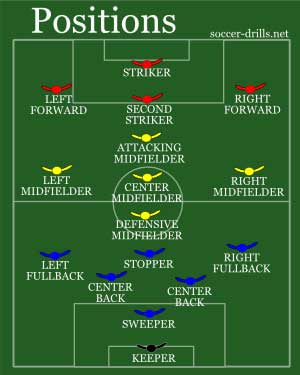

In [55]:
'''
# PositionReference.csv is the reference file on position based on player's x-,y- axis in court
pos_ref = pd.read_csv('../data/PositionReference.csv')
player_match = pd.merge(player_match, pos_ref, 
                        on=['player_pos_x', 'player_pos_y'], how='left')
player_match = player_match.drop(['role_x', 'role_y'], 1)
'''

"\n# PositionReference.csv is the reference file on position based on player's x-,y- axis in court\npos_ref = pd.read_csv('../data/PositionReference.csv')\nplayer_match = pd.merge(player_match, pos_ref, \n                        on=['player_pos_x', 'player_pos_y'], how='left')\nplayer_match = player_match.drop(['role_x', 'role_y'], 1)\n"

In [56]:
'''
# add team name information
player_match_expnd = pd.merge(player_match, team[['team_api_id', 'team_long_name']], on=['team_api_id'], how='left')

# add league name information
leagues_nm = league.rename(index=str, columns={"id": "league_id", "name": "league_name"})
player_match_expnd = pd.merge(player_match_expnd, leagues_nm[['league_id', 'league_name']], on=['league_id'], how='left')

# add player name information
player_match_expnd = pd.merge(player_match_expnd, player[['player_api_id', 'player_name']], on=['player_api_id'], how='left')
'''

'\n# add team name information\nplayer_match_expnd = pd.merge(player_match, team[[\'team_api_id\', \'team_long_name\']], on=[\'team_api_id\'], how=\'left\')\n\n# add league name information\nleagues_nm = league.rename(index=str, columns={"id": "league_id", "name": "league_name"})\nplayer_match_expnd = pd.merge(player_match_expnd, leagues_nm[[\'league_id\', \'league_name\']], on=[\'league_id\'], how=\'left\')\n\n# add player name information\nplayer_match_expnd = pd.merge(player_match_expnd, player[[\'player_api_id\', \'player_name\']], on=[\'player_api_id\'], how=\'left\')\n'

In [57]:
'''
# review player match results
player_match_expnd.loc[(player_match_expnd['player_name'] == 'Lionel Messi') & 
                       (player_match_expnd['season'] == '2010/2011') & 
                       (player_match_expnd['role_xy'] == 'LW') 
                      ]
'''

"\n# review player match results\nplayer_match_expnd.loc[(player_match_expnd['player_name'] == 'Lionel Messi') & \n                       (player_match_expnd['season'] == '2010/2011') & \n                       (player_match_expnd['role_xy'] == 'LW') \n                      ]\n"

In [58]:
'''
# write and save to csv
player_match_expnd.to_csv('../data/player_match_expnd.csv', index=False)
'''

"\n# write and save to csv\nplayer_match_expnd.to_csv('../data/player_match_expnd.csv', index=False)\n"

### Extract Match Statistic

Extract detailed match information from "goal", "shoton", "shotoff", "foulcommit", "card", "cross", "corner" and "possession" columns where data were complied in XML form. References on tags inside the XML could be found from http://eclient.enetpulse.com/documentation/article_view/25/2.


### Define Functions

Parsing xml tags using functions from jiezi2004 on Kaggle. [Source](https://www.kaggle.com/jiezi2004/the-beautiful-game-1-data-preparation)

In [59]:
'''
# get all tags in xml
def getTags(xMLcolumnNm):
    elemList = []
    # iterate each row in the XML column
    for index, row in match[pd.notnull(match[xMLcolumnNm])].iterrows():
        # read in xml data
        tree = ET.ElementTree(ET.fromstring(row[xMLcolumnNm]))
        for elem in tree.iter():
            elemList.append(elem.tag) # append tag name

    # remove duplicates of tag names
    return list(set(elemList))
'''

'\n# get all tags in xml\ndef getTags(xMLcolumnNm):\n    elemList = []\n    # iterate each row in the XML column\n    for index, row in match[pd.notnull(match[xMLcolumnNm])].iterrows():\n        # read in xml data\n        tree = ET.ElementTree(ET.fromstring(row[xMLcolumnNm]))\n        for elem in tree.iter():\n            elemList.append(elem.tag) # append tag name\n\n    # remove duplicates of tag names\n    return list(set(elemList))\n'

Define functions to get all data by tags from XML columns.


In [60]:
'''
# parse all information from XML column
def parseXMLData(xMLcolumnNm):
    tags = getTags(xMLcolumnNm) # get a list of all tags
       
    tagLists = {} # host all other tags
    pos = []
    otherList = {'match_id':[], 'pos_x':[], 'pos_y':[]} # host match id
    
    for tag in tags:
        tagLists[tag] = [] # initiate tag lists   
        
    for index, row in match[pd.notnull(match[xMLcolumnNm])].iterrows():
        game_id = row['id'] # this helps identify match
        # rea-in XML data
        tree = ET.ElementTree(ET.fromstring(row[xMLcolumnNm]))
        root = tree.getroot()  
        
        for event in root.findall('value'):
            otherList['match_id'].append(game_id)
            for tag in tags:
                if(event.find(tag) is None):
                    tagLists[tag].append(None)
                else:
                    tagLists[tag].append(event.find(tag).text) 
                    
            # get position information
            if(event.find('coordinates') is None): 
                pos.append(None)
                pos.append(None)
            else:  
                for value in event.findall("coordinates/value"):
                    pos.append(value.text)
                    
    otherList['pos_y'] = pos[1::2]  # Elements from list1 starting from 1 iterating by 2
    otherList['pos_x'] = pos[0::2]  # Elements from list1 starting from 0 iterating by 2
            
    xmlInfo = {**otherList, **tagLists}
    return pd.DataFrame(xmlInfo)
'''

'\n# parse all information from XML column\ndef parseXMLData(xMLcolumnNm):\n    tags = getTags(xMLcolumnNm) # get a list of all tags\n       \n    tagLists = {} # host all other tags\n    pos = []\n    otherList = {\'match_id\':[], \'pos_x\':[], \'pos_y\':[]} # host match id\n    \n    for tag in tags:\n        tagLists[tag] = [] # initiate tag lists   \n        \n    for index, row in match[pd.notnull(match[xMLcolumnNm])].iterrows():\n        game_id = row[\'id\'] # this helps identify match\n        # rea-in XML data\n        tree = ET.ElementTree(ET.fromstring(row[xMLcolumnNm]))\n        root = tree.getroot()  \n        \n        for event in root.findall(\'value\'):\n            otherList[\'match_id\'].append(game_id)\n            for tag in tags:\n                if(event.find(tag) is None):\n                    tagLists[tag].append(None)\n                else:\n                    tagLists[tag].append(event.find(tag).text) \n                    \n            # get position inform

#### Get Detailed Match Statistics

Get detailed information out of XML columns and store into dataframe.

In [61]:
'''
# get all xml column information
goal_detail = parseXMLData('goal')
shoton_detail = parseXMLData('shoton')
shotoff_detail = parseXMLData('shotoff')
foulcommit_detail = parseXMLData('foulcommit')
card_detail = parseXMLData('card')
cross_detail = parseXMLData('cross')
corner_detail = parseXMLData('corner')
possession_detail = parseXMLData('possession')
'''

"\n# get all xml column information\ngoal_detail = parseXMLData('goal')\nshoton_detail = parseXMLData('shoton')\nshotoff_detail = parseXMLData('shotoff')\nfoulcommit_detail = parseXMLData('foulcommit')\ncard_detail = parseXMLData('card')\ncross_detail = parseXMLData('cross')\ncorner_detail = parseXMLData('corner')\npossession_detail = parseXMLData('possession')\n"

In [62]:
'''
# export xml column information to csv
goal_detail.to_csv('../data/goal_detail.csv', index=False)
shoton_detail.to_csv('../data/shoton_detail.csv', index=False)
shotoff_detail.to_csv('../data/shotoff_detail.csv', index=False)
foulcommit_detail.to_csv('../data/foulcommit_detail.csv', index=False)
card_detail.to_csv('../data/card_detail.csv', index=False)
cross_detail.to_csv('../data/cross_detail.csv', index=False)
corner_detail.to_csv('../data/corner_detail.csv', index=False)
possession_detail.to_csv('../data/possession_detail.csv', index=False)
'''

"\n# export xml column information to csv\ngoal_detail.to_csv('../data/goal_detail.csv', index=False)\nshoton_detail.to_csv('../data/shoton_detail.csv', index=False)\nshotoff_detail.to_csv('../data/shotoff_detail.csv', index=False)\nfoulcommit_detail.to_csv('../data/foulcommit_detail.csv', index=False)\ncard_detail.to_csv('../data/card_detail.csv', index=False)\ncross_detail.to_csv('../data/cross_detail.csv', index=False)\ncorner_detail.to_csv('../data/corner_detail.csv', index=False)\npossession_detail.to_csv('../data/possession_detail.csv', index=False)\n"

In [63]:
goal_detail = pd.read_csv('../data/goal_detail.csv')
shoton_detail = pd.read_csv('../data/shoton_detail.csv')
shotoff_detail = pd.read_csv('../data/shotoff_detail.csv')
foulcommit_detail = pd.read_csv('../data/foulcommit_detail.csv')
card_detail = pd.read_csv('../data/card_detail.csv')
cross_detail = pd.read_csv('../data/cross_detail.csv')
corner_detail = pd.read_csv('../data/corner_detail.csv')
possession_detail = pd.read_csv('../data/possession_detail.csv')

/home/pug/data_science/DSIA/VE/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/pug/data_science/DSIA/VE/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (3,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/pug/data_science/DSIA/VE/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (3,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/pug/data_science/DSIA/VE/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (3,5,6,13) have mixed types. Specify dtype option on import or set low_memory=Fal

In [64]:
goal_detail.head()

match_id  pos_x  pos_y  coordinates  shoton  penalties  goal   subtype  \
0      1729    NaN    NaN          NaN     NaN        NaN   NaN    header   
1      1729    NaN    NaN          NaN     NaN        NaN   NaN      shot   
2      1730    NaN    NaN          NaN     NaN        NaN   NaN      shot   
3      1731    NaN    NaN          NaN     NaN        NaN   NaN  distance   
4      1732    NaN    NaN          NaN     NaN        NaN   NaN      shot   

   player2  goals      id  shotoff goal_type  elapsed comment  owngoals  \
0  38807.0    NaN  378998      NaN         n       22       n       NaN   
1  24154.0    NaN  379019      NaN         n       24       n       NaN   
2  39297.0    NaN  375546      NaN         n        4       n       NaN   
3  30889.0    NaN  378041      NaN         n       83       n       NaN   
4  36394.0    NaN  376060      NaN         n        4       n       NaN   

      team  del    n  elapsed_plus  player1  event_incident_typefk  value  \
0  10261.0  NaN  295           NaN  37799.0                    406    NaN   
1  10260.0  NaN  298           NaN  24148.0                    393    NaN   
2   9825.0  NaN  231           NaN  26181.0                    393    NaN   
3   8650.0  NaN  344           NaN  30853.0                    407    NaN   
4   8654.0  NaN  244           NaN  23139.0                    393    NaN   

   sortorder stats  type  
0          5   NaN  goal  
1          4   NaN  goal  
2          2   NaN  goal  
3          0   NaN  goal  
4          2   NaN  goal

In [65]:
goal_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39980 entries, 0 to 39979
Data columns (total 26 columns):
match_id                 39980 non-null int64
pos_x                    11078 non-null float64
pos_y                    11078 non-null float64
coordinates              0 non-null float64
shoton                   0 non-null float64
penalties                0 non-null float64
goal                     0 non-null float64
subtype                  21551 non-null object
player2                  17069 non-null float64
goals                    0 non-null float64
id                       39980 non-null int64
shotoff                  0 non-null float64
goal_type                39946 non-null object
elapsed                  39980 non-null int64
comment                  39980 non-null object
owngoals                 0 non-null float64
team                     39946 non-null float64
del                      34 non-null float64
n                        39980 non-null int64
elapsed_plus         

In [66]:
goal_detail.isna().sum()

match_id                     0
pos_x                    28902
pos_y                    28902
coordinates              39980
shoton                   39980
penalties                39980
goal                     39980
subtype                  18429
player2                  22911
goals                    39980
id                           0
shotoff                  39980
goal_type                   34
elapsed                      0
comment                      0
owngoals                 39980
team                        34
del                      39946
n                            0
elapsed_plus             38320
player1                    117
event_incident_typefk        0
value                    39980
sortorder                    0
stats                    39978
type                         0
dtype: int64

In [67]:
shoton_detail.head()

match_id  pos_x  pos_y card_type  blocked  player1  coordinates  \
0      1729    NaN    NaN       NaN      NaN  24154.0          NaN   
1      1729    NaN    NaN       NaN      NaN  24157.0          NaN   
2      1729    NaN    NaN       NaN      NaN  30829.0          NaN   
3      1729    NaN    NaN       NaN      NaN  30373.0          NaN   
4      1729    NaN    NaN       NaN      NaN  30373.0          NaN   

   event_incident_typefk  shoton     team  value       subtype  sortorder  \
0                     61     NaN  10260.0    NaN  blocked_shot          0   
1                    154     NaN  10260.0    NaN        header          2   
2                    153     NaN  10260.0    NaN          shot          1   
3                    153     NaN  10260.0    NaN          shot          2   
4                    137     NaN  10260.0    NaN      distance          3   

  stats goal_type  del    n  elapsed_plus    type      id  elapsed  
0   NaN       NaN  NaN  253           NaN  shoton  378828        3  
1   NaN       NaN  NaN  258           NaN  shoton  378866        7  
2   NaN       NaN  NaN  274           NaN  shoton  378922       14  
3   NaN       NaN  NaN  279           NaN  shoton  378923       14  
4   NaN       NaN  NaN  272           NaN  shoton  378951       17

In [68]:
shoton_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93755 entries, 0 to 93754
Data columns (total 21 columns):
match_id                 93755 non-null int64
pos_x                    42982 non-null float64
pos_y                    42982 non-null float64
card_type                1 non-null object
blocked                  0 non-null float64
player1                  92802 non-null float64
coordinates              0 non-null float64
event_incident_typefk    93755 non-null int64
shoton                   0 non-null float64
team                     93684 non-null float64
value                    0 non-null float64
subtype                  93737 non-null object
sortorder                93755 non-null int64
stats                    14 non-null object
goal_type                2 non-null object
del                      70 non-null float64
n                        93755 non-null int64
elapsed_plus             5968 non-null float64
type                     93755 non-null object
id                     

In [69]:
shoton_detail.isna().sum()

match_id                     0
pos_x                    50773
pos_y                    50773
card_type                93754
blocked                  93755
player1                    953
coordinates              93755
event_incident_typefk        0
shoton                   93755
team                        71
value                    93755
subtype                     18
sortorder                    0
stats                    93741
goal_type                93753
del                      93685
n                            0
elapsed_plus             87787
type                         0
id                           0
elapsed                      0
dtype: int64

In [70]:
shotoff_detail.head()

match_id  pos_x  pos_y card_type  shotoff  player1  coordinates  \
0      1729    NaN    NaN       NaN      NaN  30373.0          NaN   
1      1729    NaN    NaN       NaN      NaN  37799.0          NaN   
2      1729    NaN    NaN       NaN      NaN  24228.0          NaN   
3      1729    NaN    NaN       NaN      NaN  38807.0          NaN   
4      1729    NaN    NaN       NaN      NaN  24154.0          NaN   

   event_incident_typefk     team  value    subtype  sortorder stats  del  \
0                      9  10260.0    NaN   distance          1   NaN  NaN   
1                      9  10261.0    NaN   distance          2   NaN  NaN   
2                    317  10261.0    NaN  deflected          3   NaN  NaN   
3                      9  10261.0    NaN   distance          0   NaN  NaN   
4                     47  10260.0    NaN     header          2   NaN  NaN   

     n  elapsed_plus     type      id  elapsed  
0  264           NaN  shotoff  378835        4  
1  257           NaN  shotoff  378845        5  
2  269           NaN  shotoff  378995       22  
3  278           NaN  shotoff  379075       31  
4  281           NaN  shotoff  379111       34

In [71]:
shotoff_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95303 entries, 0 to 95302
Data columns (total 19 columns):
match_id                 95303 non-null int64
pos_x                    42206 non-null float64
pos_y                    42206 non-null float64
card_type                2 non-null object
shotoff                  0 non-null float64
player1                  94659 non-null float64
coordinates              0 non-null float64
event_incident_typefk    95303 non-null int64
team                     95246 non-null float64
value                    0 non-null float64
subtype                  95114 non-null object
sortorder                95303 non-null int64
stats                    8 non-null object
del                      57 non-null float64
n                        95303 non-null int64
elapsed_plus             5972 non-null float64
type                     95303 non-null object
id                       95303 non-null int64
elapsed                  95303 non-null int64
dtypes: float64(9),

In [72]:
shotoff_detail.isna().sum()

match_id                     0
pos_x                    53097
pos_y                    53097
card_type                95301
shotoff                  95303
player1                    644
coordinates              95303
event_incident_typefk        0
team                        57
value                    95303
subtype                    189
sortorder                    0
stats                    95295
del                      95246
n                            0
elapsed_plus             89331
type                         0
id                           0
elapsed                      0
dtype: int64

In [73]:
foulcommit_detail.head()

match_id  pos_x  pos_y card_type  coordinates player1 venue  foulcommit  \
0      1729    NaN    NaN       NaN          NaN   25518   NaN         NaN   
1      1729    NaN    NaN       NaN          NaN   30929   NaN         NaN   
2      1729    NaN    NaN       NaN          NaN   29581   NaN         NaN   
3      1729    NaN    NaN       NaN          NaN   30373   NaN         NaN   
4      1729    NaN    NaN       NaN          NaN   29581   NaN         NaN   

   event_incident_typefk     team  value  sortorder  subtype stats  del  \
0                     37  10261.0    NaN          1      NaN   NaN  NaN   
1                     37  10261.0    NaN          0      NaN   NaN  NaN   
2                     37  10261.0    NaN          1      NaN   NaN  NaN   
3                     37  10260.0    NaN          0      NaN   NaN  NaN   
4                    320  10261.0    NaN          0  pushing   NaN  NaN   

   injury_time        type    n  player2  foulscommitted  elapsed_plus  \
0          NaN  foulcommit  267  32569.0             NaN           NaN   
1          NaN  foulcommit  277  24157.0             NaN           NaN   
2          NaN  foulcommit  254  24148.0             NaN           NaN   
3          NaN  foulcommit  256  40565.0             NaN           NaN   
4          NaN  foulcommit  275  30829.0             NaN           NaN   

       id  elapsed  
0  378824        1  
1  378826        2  
2  378830        3  
3  378841        5  
4  378894       10

In [74]:
foulcommit_detail.match_id.value_counts()

12668    55
12946    53
13237    52
12843    52
10301    52
         ..
3082      6
22583     4
7966      3
22254     1
10315     1
Name: match_id, Length: 8465, dtype: int64

In [75]:
foulcommit_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219234 entries, 0 to 219233
Data columns (total 23 columns):
match_id                 219234 non-null int64
pos_x                    106826 non-null float64
pos_y                    106826 non-null float64
card_type                14 non-null object
coordinates              0 non-null float64
player1                  211406 non-null object
venue                    2 non-null object
foulcommit               0 non-null float64
event_incident_typefk    219234 non-null int64
team                     218824 non-null float64
value                    0 non-null float64
sortorder                219234 non-null int64
subtype                  116380 non-null object
stats                    16 non-null object
del                      409 non-null float64
injury_time              2 non-null float64
type                     219234 non-null object
n                        219234 non-null int64
player2                  190897 non-null float64
foulscom

In [76]:
foulcommit_detail.isna().sum()

match_id                      0
pos_x                    112408
pos_y                    112408
card_type                219220
coordinates              219234
player1                    7828
venue                    219232
foulcommit               219234
event_incident_typefk         0
team                        410
value                    219234
sortorder                     0
subtype                  102854
stats                    219218
del                      218825
injury_time              219232
type                          0
n                             0
player2                   28337
foulscommitted           219234
elapsed_plus             206102
id                            0
elapsed                       0
dtype: int64

In [77]:
card_detail.head()

match_id  pos_x  pos_y card_type comment player1  event_incident_typefk  \
0      1729    NaN    NaN         y       y   24157                     73   
1      1729    NaN    NaN         y       y   30362                     73   
2      1729    NaN    NaN         y       y   30829                     70   
3      1731    NaN    NaN         y       y   37442                     73   
4      1731    NaN    NaN         y       y   46621                     25   

   ycards     team  value        subtype  sortorder stats  rcards  del  \
0     NaN  10260.0    NaN  serious_fouls          1   NaN     NaN  NaN   
1     NaN  10260.0    NaN  serious_fouls          1   NaN     NaN  NaN   
2     NaN  10260.0    NaN            NaN          1   NaN     NaN  NaN   
3     NaN   8650.0    NaN  serious_fouls          5   NaN     NaN  NaN   
4     NaN   8650.0    NaN     stall_time          3   NaN     NaN  NaN   

  goal_type    n  elapsed_plus  type  card      id  elapsed  
0       NaN  342           NaN  card   NaN  379481       78  
1       NaN  346           NaN  card   NaN  379503       82  
2       NaN  353           NaN  card   NaN  379547       90  
3       NaN  327           NaN  card   NaN  377978       56  
4       NaN  353           NaN  card   NaN  378060       90

In [78]:
card_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62114 entries, 0 to 62113
Data columns (total 22 columns):
match_id                 62114 non-null int64
pos_x                    0 non-null float64
pos_y                    0 non-null float64
card_type                61509 non-null object
comment                  62114 non-null object
player1                  61794 non-null object
event_incident_typefk    62114 non-null int64
ycards                   0 non-null float64
team                     61794 non-null float64
value                    0 non-null float64
subtype                  18864 non-null object
sortorder                62114 non-null int64
stats                    3 non-null object
rcards                   0 non-null float64
del                      322 non-null float64
goal_type                1 non-null object
n                        62114 non-null int64
elapsed_plus             3482 non-null float64
type                     62114 non-null object
card                     

In [79]:
card_detail.isna().sum()

match_id                     0
pos_x                    62114
pos_y                    62114
card_type                  605
comment                      0
player1                    320
event_incident_typefk        0
ycards                   62114
team                       320
value                    62114
subtype                  43250
sortorder                    0
stats                    62111
rcards                   62114
del                      61792
goal_type                62113
n                            0
elapsed_plus             58632
type                         0
card                     62114
id                           0
elapsed                      0
dtype: int64

In [80]:
cross_detail.head()

match_id  pos_x  pos_y  coordinates  player1  corners  \
0      1729    NaN    NaN          NaN  30829.0      NaN   
1      1729    NaN    NaN          NaN  24148.0      NaN   
2      1729    NaN    NaN          NaN  38807.0      NaN   
3      1729    NaN    NaN          NaN  30929.0      NaN   
4      1729    NaN    NaN          NaN  24148.0      NaN   

   event_incident_typefk  spectators     team  value subtype  sortorder stats  \
0                      7         NaN  10260.0    NaN   cross          1   NaN   
1                      7         NaN  10260.0    NaN   cross          0   NaN   
2                    329         NaN  10261.0    NaN   cross          0   NaN   
3                      7         NaN  10261.0    NaN   cross          5   NaN   
4                      7         NaN  10260.0    NaN   cross          0   NaN   

   del  throwin goal_type  cross    n    type  elapsed_plus      id  crosses  \
0  NaN      NaN       NaN    NaN  265   cross           NaN  378863      NaN   
1  NaN      NaN       NaN    NaN  255   cross           NaN  378921      NaN   
2  NaN      NaN       NaN    NaN  280  corner           NaN  378960      NaN   
3  NaN      NaN       NaN    NaN  292   cross           NaN  378970      NaN   
4  NaN      NaN       NaN    NaN  259   cross           NaN  378978      NaN   

   elapsed  
0        7  
1       14  
2       19  
3       19  
4       20

In [81]:
cross_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284775 entries, 0 to 284774
Data columns (total 23 columns):
match_id                 284775 non-null int64
pos_x                    121162 non-null float64
pos_y                    121162 non-null float64
coordinates              0 non-null float64
player1                  271419 non-null float64
corners                  0 non-null float64
event_incident_typefk    284775 non-null int64
spectators               1 non-null float64
team                     284594 non-null float64
value                    0 non-null float64
subtype                  284775 non-null object
sortorder                284775 non-null int64
stats                    41 non-null object
del                      178 non-null float64
throwin                  0 non-null float64
goal_type                1 non-null object
cross                    0 non-null float64
n                        284775 non-null int64
type                     284775 non-null object
elapsed_plus

In [82]:
cross_detail.isna().sum()

match_id                      0
pos_x                    163613
pos_y                    163613
coordinates              284775
player1                   13356
corners                  284775
event_incident_typefk         0
spectators               284774
team                        181
value                    284775
subtype                       0
sortorder                     0
stats                    284734
del                      284597
throwin                  284775
goal_type                284774
cross                    284775
n                             0
type                          0
elapsed_plus             268656
id                            0
crosses                  284775
elapsed                       0
dtype: int64

In [83]:
corner_detail.head()

match_id  pos_x  pos_y  coordinates  corners  player1  \
0      1729    NaN    NaN          NaN      NaN  38807.0   
1      1729    NaN    NaN          NaN      NaN  40565.0   
2      1729    NaN    NaN          NaN      NaN  38807.0   
3      1729    NaN    NaN          NaN      NaN  24154.0   
4      1729    NaN    NaN          NaN      NaN  38807.0   

   event_incident_typefk  spectators     team  value subtype  sortorder stats  \
0                    329         NaN  10261.0    NaN   cross          0   NaN   
1                    330         NaN  10261.0    NaN   short          0   NaN   
2                    329         NaN  10261.0    NaN   cross          4   NaN   
3                    329         NaN  10260.0    NaN   cross          2   NaN   
4                    329         NaN  10261.0    NaN   cross          0   NaN   

   del  corner    n  elapsed_plus    type      id  elapsed  
0  NaN     NaN  280           NaN  corner  378960       19  
1  NaN     NaN  263           NaN  corner  378992       22  
2  NaN     NaN  293           NaN  corner  378996       22  
3  NaN     NaN  300           NaN  corner  379352       48  
4  NaN     NaN  301           NaN  corner  379366       51

In [84]:
corner_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87839 entries, 0 to 87838
Data columns (total 20 columns):
match_id                 87839 non-null int64
pos_x                    40005 non-null float64
pos_y                    40005 non-null float64
coordinates              0 non-null float64
corners                  0 non-null float64
player1                  85376 non-null float64
event_incident_typefk    87839 non-null int64
spectators               1 non-null float64
team                     87753 non-null float64
value                    0 non-null float64
subtype                  87676 non-null object
sortorder                87839 non-null int64
stats                    8 non-null object
del                      86 non-null float64
corner                   0 non-null float64
n                        87839 non-null int64
elapsed_plus             5603 non-null float64
type                     87839 non-null object
id                       87839 non-null int64
elapsed             

In [85]:
corner_detail.isna().sum()

match_id                     0
pos_x                    47834
pos_y                    47834
coordinates              87839
corners                  87839
player1                   2463
event_incident_typefk        0
spectators               87838
team                        86
value                    87839
subtype                    163
sortorder                    0
stats                    87831
del                      87753
corner                   87839
n                            0
elapsed_plus             82236
type                         0
id                           0
elapsed                      0
dtype: int64

In [86]:
possession_detail.head()

match_id  pos_x  pos_y card_type comment  possession  \
0      1729    NaN    NaN       NaN      56         NaN   
1      1729    NaN    NaN       NaN      54         NaN   
2      1729    NaN    NaN       NaN      54         NaN   
3      1729    NaN    NaN       NaN      55         NaN   
4      1730    NaN    NaN       NaN      65         NaN   

   event_incident_typefk  injury_time  value     subtype  sortorder goal_type  \
0                    352          NaN    NaN  possession          1       NaN   
1                    352          NaN    NaN  possession          4       NaN   
2                    352          NaN    NaN  possession          0       NaN   
3                    352          NaN    NaN  possession          1       NaN   
4                    352          NaN    NaN  possession          0       NaN   

   del  homepos  stats    n  elapsed_plus     type      id  awaypos  elapsed  
0  NaN     56.0    NaN   68           NaN  special  379029     44.0       25  
1  NaN     54.0    NaN  117           1.0  special  379251     46.0       45  
2  NaN     54.0    NaN  190           NaN  special  379443     46.0       70  
3  NaN     55.0    NaN  252           5.0  special  379575     45.0       90  
4  NaN     65.0    NaN   67           NaN  special  375608     35.0       27

In [87]:
possession_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34815 entries, 0 to 34814
Data columns (total 21 columns):
match_id                 34815 non-null int64
pos_x                    0 non-null float64
pos_y                    0 non-null float64
card_type                1 non-null object
comment                  34813 non-null object
possession               0 non-null float64
event_incident_typefk    34815 non-null int64
injury_time              2 non-null float64
value                    0 non-null float64
subtype                  34815 non-null object
sortorder                34815 non-null int64
goal_type                1 non-null object
del                      17 non-null float64
homepos                  34796 non-null float64
stats                    0 non-null float64
n                        34815 non-null int64
elapsed_plus             6320 non-null float64
type                     34815 non-null object
id                       34815 non-null int64
awaypos                  34796

In [88]:
possession_detail.isna().sum()

match_id                     0
pos_x                    34815
pos_y                    34815
card_type                34814
comment                      2
possession               34815
event_incident_typefk        0
injury_time              34813
value                    34815
subtype                      0
sortorder                    0
goal_type                34814
del                      34798
homepos                     19
stats                    34815
n                            0
elapsed_plus             28495
type                         0
id                           0
awaypos                     19
elapsed                      0
dtype: int64

In [89]:
#df = pd.merge(match, team[['team_long_name','team_short_name','team_api_id']], left_on=['home_team_api_id'],right_on=['team_api_id'], how='left')

In [90]:
#df.head()

In [91]:
#df = df.rename(columns={'team_long_name':'home_team_long_name','team_short_name':'home_team_short_name'})

In [92]:
#df.head()

In [93]:
#df=df.drop('team_api_id',axis=1)

In [94]:
#team_attributes.head()

In [95]:
#df1 = pd.merge(df, team_attributes, left_on=['home_team_api_id'],right_on=['team_api_id'], how='left')

In [96]:
#df1.head()

In [97]:
#for col in team_attributes.columns:
#    print(col)

## Exploring the scope of the team data

I suspect that the xml data is not very useful in predicting the outcome of the games as this data provides very detailed match data, after the outcome is known. Hence I suspect the base team and player data sourced from the FIFA game would be far more useful in terms of detailed analysis. Below, I join the 2015 team data to the match table for the 2015/16 season. In principle could do the same with players.

In [98]:
team_attributes.dtypes

team_fifa_api_id                    int64
team_api_id                         int64
date                               object
buildUpPlaySpeed                    int64
buildUpPlaySpeedClass              object
buildUpPlayDribbling              float64
buildUpPlayDribblingClass          object
buildUpPlayPassing                  int64
buildUpPlayPassingClass            object
buildUpPlayPositioningClass        object
chanceCreationPassing               int64
chanceCreationPassingClass         object
chanceCreationCrossing              int64
chanceCreationCrossingClass        object
chanceCreationShooting              int64
chanceCreationShootingClass        object
chanceCreationPositioningClass     object
defencePressure                     int64
defencePressureClass               object
defenceAggression                   int64
defenceAggressionClass             object
defenceTeamWidth                    int64
defenceTeamWidthClass              object
defenceDefenderLineClass          

In [99]:
team_attributes['date'] = pd.to_datetime(team_attributes['date'])

In [100]:
team_attributes.date.dt.year==2015

id
1       False
2       False
3        True
4       False
5       False
        ...  
1454    False
1455    False
1456    False
1457    False
1458     True
Name: date, Length: 1458, dtype: bool

In [101]:
team_attributes[team_attributes.date.dt.year==2015]

team_fifa_api_id  team_api_id       date  buildUpPlaySpeed  \
id                                                                 
3                  434         9930 2015-09-10                47   
9                   77         8485 2015-09-10                59   
15                 614         8576 2015-09-10                59   
21                  47         8564 2015-09-10                48   
27                1901        10215 2015-09-10                53   
...                ...          ...        ...               ...   
1426               110         8602 2015-09-10                46   
1439               900        10192 2015-09-10                52   
1450               244         8394 2015-09-10                52   
1452            112512         8027 2015-09-10                54   
1458             15005        10000 2015-09-10                54   

     buildUpPlaySpeedClass  buildUpPlayDribbling buildUpPlayDribblingClass  \
id                                                                           
3                 Balanced                  41.0                    Normal   
9                 Balanced                  64.0                    Normal   
15                Balanced                  57.0                    Normal   
21                Balanced                  70.0                      Lots   
27                Balanced                  53.0                    Normal   
...                    ...                   ...                       ...   
1426              Balanced                  36.0                    Normal   
1439              Balanced                  56.0                    Normal   
1450              Balanced                  52.0                    Normal   
1452              Balanced                  51.0                    Normal   
1458              Balanced                  42.0                    Normal   

      buildUpPlayPassing buildUpPlayPassingClass buildUpPlayPositioningClass  \
id                                                                             
3                     54                   Mixed                   Organised   
9                     53                   Mixed                   Organised   
15                    52                   Mixed                   Organised   
21                    52                   Mixed                   Organised   
27                    44                   Mixed                   Organised   
...                  ...                     ...                         ...   
1426                  54                   Mixed                   Organised   
1439                  64                   Mixed                   Organised   
1450                  50                   Mixed                   Organised   
1452                  40                   Mixed                   Organised   
1458                  51                   Mixed                   Organised   

      chanceCreationPassing chanceCreationPassingClass  \
id                                                       
3                        54                     Normal   
9                        51                     Normal   
15                       48                     Normal   
21                       66                     Normal   
27                       55                     Normal   
...                     ...                        ...   
1426                     55                     Normal   
1439                     39                     Normal   
1450                     52                     Normal   
1452                     46                     Normal   
1458                     47                     Normal   

      chanceCreationCrossing chanceCreationCrossingClass  \
id                                                         
3                         63                      Normal   
9                         72                        Lots   
15                        38                      Normal   
21        

In [102]:
len(team_attributes[team_attributes.date.dt.year==2015].team_api_id.unique())

244

In [103]:
team_attributes_2015 = team_attributes[team_attributes.date.dt.year==2015]

In [104]:
team_attributes_2015 = team_attributes_2015.drop_duplicates()

In [105]:
match.season.unique()

array(['2008/2009', '2009/2010', '2010/2011', '2011/2012', '2012/2013',
       '2013/2014', '2014/2015', '2015/2016'], dtype=object)

In [106]:
match.dtypes

id                    int64
country_id            int64
league_id             int64
season               object
stage                 int64
date                 object
match_api_id          int64
home_team_api_id      int64
away_team_api_id      int64
home_team_goal        int64
away_team_goal        int64
home_player_X1      float64
home_player_X2      float64
home_player_X3      float64
home_player_X4      float64
home_player_X5      float64
home_player_X6      float64
home_player_X7      float64
home_player_X8      float64
home_player_X9      float64
home_player_X10     float64
home_player_X11     float64
away_player_X1      float64
away_player_X2      float64
away_player_X3      float64
away_player_X4      float64
away_player_X5      float64
away_player_X6      float64
away_player_X7      float64
away_player_X8      float64
away_player_X9      float64
away_player_X10     float64
away_player_X11     float64
home_player_Y1      float64
home_player_Y2      float64
home_player_Y3      

In [107]:
match_15_16 = match[match.season=='2015/2016']

In [108]:
match_15_16.shape

(3326, 115)

In [109]:
player_attributes['date'] = pd.to_datetime(player_attributes['date'])

In [110]:
player_attributes_2015 = player_attributes[player_attributes.date.dt.year==2015]

In [111]:
df = pd.merge(match_15_16, team_attributes_2015, left_on=['home_team_api_id'],right_on=['team_api_id'], how='inner')

In [112]:
df.shape

(3129, 139)

In [113]:
dic = {}
for col in team_attributes:
    dic[col] = 'home_'+col

In [114]:
df.head()

id  country_id  league_id     season  stage               date_x  \
0  1490           1          1  2015/2016      1  2015-07-25 00:00:00   
1  1511           1          1  2015/2016     11  2015-10-18 00:00:00   
2  1527           1          1  2015/2016     13  2015-10-29 00:00:00   
3  1543           1          1  2015/2016     15  2015-11-07 00:00:00   
4  1557           1          1  2015/2016     17  2015-11-28 00:00:00   

   match_api_id  home_team_api_id  away_team_api_id  home_team_goal  \
0       1979833              8571              9985               2   
1       1979910              8571              9986               2   
2       1979926              8571              8635               1   
3       1979942              8571              8203               1   
4       1979956              8571              8475               3   

   away_team_goal  home_player_X1  home_player_X2  home_player_X3  \
0               1             1.0             2.0             4.0   
1               0             1.0             2.0             4.0   
2               1             1.0             2.0             4.0   
3               0             1.0             2.0             4.0   
4               1             1.0             2.0             4.0   

   home_player_X4  home_player_X5  home_player_X6  home_player_X7  \
0             6.0             8.0             2.0             4.0   
1             6.0             8.0             3.0             5.0   
2             6.0             8.0             4.0             6.0   
3             6.0             8.0             3.0             5.0   
4             6.0             8.0             3.0             5.0   

   home_player_X8  home_player_X9  home_player_X10  home_player_X11  \
0             6.0             8.0              4.0              6.0   
1             7.0             3.0              5.0              7.0   
2             3.0             5.0              7.0              5.0   
3             7.0             3.0              5.0              7.0   
4             7.0             3.0              5.0              7.0   

   away_player_X1  away_player_X2  away_player_X3  away_player_X4  \
0             1.0             2.0             4.0             6.0   
1             1.0             2.0             4.0             6.0   
2             1.0             2.0             4.0             6.0   
3             1.0             2.0             4.0             6.0   
4             1.0             2.0             4.0             6.0   

   away_player_X5  away_player_X6  away_player_X7  away_player_X8  \
0             8.0             3.0             5.0             7.0   
1             8.0             3.0             5.0             7.0   
2             8.0             5.0             2.0             4.0   
3             8.0             3.0             5.0             7.0   
4             8.0             3.0             5.0             7.0   

   away_player_X9  away_player_X10  away_player_X11  home_player_Y1  \
0             3.0              5.0              7.0             1.0   
1             3.0              5.0              7.0             1.0   
2             6.0              8.0              5.0             1.0   
3             3.0              5.0              7.0             1.0   
4             3.0              5.0              7.0             1.0   

   home_player_Y2  home_player_Y3  home_player_Y4  home_player_Y5  \
0             3.0             3.0             3.0             3.0   
1             3.0             3.0             3.0             3.0   
2             3.0             3.0             3.0             3.0   
3             3.0             3.0             3.0             3.0   
4             3.0             3.0             3.0             3.0   

   home_player_Y6  home_player_Y7  home_player_Y8  home_player_Y9  \
0             7.0             7.0             7.0             7.0   
1             7.0             7.0             7.0            10.0   
2  

In [115]:
del dic['date']

In [116]:
dic['date_y']='home_date'

In [117]:
dic['date_x']='match_date'

In [118]:
df = df.rename(columns=dic)

In [119]:
df.head()

id  country_id  league_id     season  stage           match_date  \
0  1490           1          1  2015/2016      1  2015-07-25 00:00:00   
1  1511           1          1  2015/2016     11  2015-10-18 00:00:00   
2  1527           1          1  2015/2016     13  2015-10-29 00:00:00   
3  1543           1          1  2015/2016     15  2015-11-07 00:00:00   
4  1557           1          1  2015/2016     17  2015-11-28 00:00:00   

   match_api_id  home_team_api_id  away_team_api_id  home_team_goal  \
0       1979833              8571              9985               2   
1       1979910              8571              9986               2   
2       1979926              8571              8635               1   
3       1979942              8571              8203               1   
4       1979956              8571              8475               3   

   away_team_goal  home_player_X1  home_player_X2  home_player_X3  \
0               1             1.0             2.0             4.0   
1               0             1.0             2.0             4.0   
2               1             1.0             2.0             4.0   
3               0             1.0             2.0             4.0   
4               1             1.0             2.0             4.0   

   home_player_X4  home_player_X5  home_player_X6  home_player_X7  \
0             6.0             8.0             2.0             4.0   
1             6.0             8.0             3.0             5.0   
2             6.0             8.0             4.0             6.0   
3             6.0             8.0             3.0             5.0   
4             6.0             8.0             3.0             5.0   

   home_player_X8  home_player_X9  home_player_X10  home_player_X11  \
0             6.0             8.0              4.0              6.0   
1             7.0             3.0              5.0              7.0   
2             3.0             5.0              7.0              5.0   
3             7.0             3.0              5.0              7.0   
4             7.0             3.0              5.0              7.0   

   away_player_X1  away_player_X2  away_player_X3  away_player_X4  \
0             1.0             2.0             4.0             6.0   
1             1.0             2.0             4.0             6.0   
2             1.0             2.0             4.0             6.0   
3             1.0             2.0             4.0             6.0   
4             1.0             2.0             4.0             6.0   

   away_player_X5  away_player_X6  away_player_X7  away_player_X8  \
0             8.0             3.0             5.0             7.0   
1             8.0             3.0             5.0             7.0   
2             8.0             5.0             2.0             4.0   
3             8.0             3.0             5.0             7.0   
4             8.0             3.0             5.0             7.0   

   away_player_X9  away_player_X10  away_player_X11  home_player_Y1  \
0             3.0              5.0              7.0             1.0   
1             3.0              5.0              7.0             1.0   
2             6.0              8.0              5.0             1.0   
3             3.0              5.0              7.0             1.0   
4             3.0              5.0              7.0             1.0   

   home_player_Y2  home_player_Y3  home_player_Y4  home_player_Y5  \
0             3.0             3.0             3.0             3.0   
1             3.0             3.0             3.0             3.0   
2             3.0             3.0             3.0             3.0   
3             3.0             3.0             3.0             3.0   
4             3.0             3.0             3.0             3.0   

   home_player_Y6  home_player_Y7  home_player_Y8  home_player_Y9  \
0             7.0             7.0             7.0             7.0   
1             7.0             7.0             7.0            10.0   
2  

In [120]:
df = pd.merge(df, team_attributes_2015, left_on=['away_team_api_id'],right_on=['team_api_id'], how='inner')

In [121]:
df.head()

id  country_id  league_id     season  stage           match_date  \
0  1490           1          1  2015/2016      1  2015-07-25 00:00:00   
1  1499           1          1  2015/2016     10  2015-10-04 00:00:00   
2  1588           1          1  2015/2016     20  2015-12-20 00:00:00   
3  1556           1          1  2015/2016     17  2015-11-27 00:00:00   
4  1639           1          1  2015/2016     26  2016-02-14 00:00:00   

   match_api_id  home_team_api_id  away_team_api_id  home_team_goal  \
0       1979833              8571              9985               2   
1       1979898              9987              9985               3   
2       1979979              8573              9985               4   
3       1979955             10000              9985               2   
4       1980030             10001              9985               2   

   away_team_goal  home_player_X1  home_player_X2  home_player_X3  \
0               1             1.0             2.0             4.0   
1               1             1.0             2.0             4.0   
2               1             1.0             2.0             4.0   
3               3             1.0             2.0             4.0   
4               0             1.0             2.0             4.0   

   home_player_X4  home_player_X5  home_player_X6  home_player_X7  \
0             6.0             8.0             2.0             4.0   
1             6.0             8.0             4.0             6.0   
2             6.0             8.0             4.0             6.0   
3             6.0             8.0             3.0             5.0   
4             6.0             8.0             5.0             4.0   

   home_player_X8  home_player_X9  home_player_X10  home_player_X11  \
0             6.0             8.0              4.0              6.0   
1             3.0             5.0              7.0              5.0   
2             3.0             5.0              7.0              5.0   
3             7.0             3.0              5.0              7.0   
4             6.0             3.0              7.0              5.0   

   away_player_X1  away_player_X2  away_player_X3  away_player_X4  \
0             1.0             2.0             4.0             6.0   
1             1.0             2.0             4.0             6.0   
2             1.0             2.0             4.0             6.0   
3             1.0             2.0             4.0             6.0   
4             1.0             2.0             4.0             6.0   

   away_player_X5  away_player_X6  away_player_X7  away_player_X8  \
0             8.0             3.0             5.0             7.0   
1             8.0             4.0             6.0             3.0   
2             8.0             4.0             6.0             3.0   
3             8.0             3.0             5.0             7.0   
4             8.0             2.0             4.0             6.0   

   away_player_X9  away_player_X10  away_player_X11  home_player_Y1  \
0             3.0              5.0              7.0             1.0   
1             5.0              7.0              5.0             1.0   
2             5.0              7.0              5.0             1.0   
3             3.0              5.0              7.0             1.0   
4             8.0              4.0              6.0             1.0   

   home_player_Y2  home_player_Y3  home_player_Y4  home_player_Y5  \
0             3.0             3.0             3.0             3.0   
1             3.0             3.0             3.0             3.0   
2             3.0             3.0             3.0             3.0   
3             3.0             3.0             3.0             3.0   
4             3.0             3.0             3.0             3.0   

   home_player_Y6  home_player_Y7  home_player_Y8  home_player_Y9  \
0             7.0             7.0             7.0             7.0   
1             6.0             6.0             8.0             8.0   
2  

In [122]:
dic = {}
for col in team_attributes:
    dic[col] = 'away_'+col

In [123]:
df = df.rename(columns=dic)

In [124]:
df.shape

(2948, 163)

In [125]:
df.head()

id  country_id  league_id     season  stage           match_date  \
0  1490           1          1  2015/2016      1  2015-07-25 00:00:00   
1  1499           1          1  2015/2016     10  2015-10-04 00:00:00   
2  1588           1          1  2015/2016     20  2015-12-20 00:00:00   
3  1556           1          1  2015/2016     17  2015-11-27 00:00:00   
4  1639           1          1  2015/2016     26  2016-02-14 00:00:00   

   match_api_id  home_team_api_id  away_team_api_id  home_team_goal  \
0       1979833              8571              9985               2   
1       1979898              9987              9985               3   
2       1979979              8573              9985               4   
3       1979955             10000              9985               2   
4       1980030             10001              9985               2   

   away_team_goal  home_player_X1  home_player_X2  home_player_X3  \
0               1             1.0             2.0             4.0   
1               1             1.0             2.0             4.0   
2               1             1.0             2.0             4.0   
3               3             1.0             2.0             4.0   
4               0             1.0             2.0             4.0   

   home_player_X4  home_player_X5  home_player_X6  home_player_X7  \
0             6.0             8.0             2.0             4.0   
1             6.0             8.0             4.0             6.0   
2             6.0             8.0             4.0             6.0   
3             6.0             8.0             3.0             5.0   
4             6.0             8.0             5.0             4.0   

   home_player_X8  home_player_X9  home_player_X10  home_player_X11  \
0             6.0             8.0              4.0              6.0   
1             3.0             5.0              7.0              5.0   
2             3.0             5.0              7.0              5.0   
3             7.0             3.0              5.0              7.0   
4             6.0             3.0              7.0              5.0   

   away_player_X1  away_player_X2  away_player_X3  away_player_X4  \
0             1.0             2.0             4.0             6.0   
1             1.0             2.0             4.0             6.0   
2             1.0             2.0             4.0             6.0   
3             1.0             2.0             4.0             6.0   
4             1.0             2.0             4.0             6.0   

   away_player_X5  away_player_X6  away_player_X7  away_player_X8  \
0             8.0             3.0             5.0             7.0   
1             8.0             4.0             6.0             3.0   
2             8.0             4.0             6.0             3.0   
3             8.0             3.0             5.0             7.0   
4             8.0             2.0             4.0             6.0   

   away_player_X9  away_player_X10  away_player_X11  home_player_Y1  \
0             3.0              5.0              7.0             1.0   
1             5.0              7.0              5.0             1.0   
2             5.0              7.0              5.0             1.0   
3             3.0              5.0              7.0             1.0   
4             8.0              4.0              6.0             1.0   

   home_player_Y2  home_player_Y3  home_player_Y4  home_player_Y5  \
0             3.0             3.0             3.0             3.0   
1             3.0             3.0             3.0             3.0   
2             3.0             3.0             3.0             3.0   
3             3.0             3.0             3.0             3.0   
4             3.0             3.0             3.0             3.0   

   home_player_Y6  home_player_Y7  home_player_Y8  home_player_Y9  \
0             7.0             7.0             7.0             7.0   
1             6.0             6.0             8.0             8.0   
2  

In [126]:
df = df.rename(columns={'date_y':'date'})

In [127]:
df.isna().sum()

id                                        0
country_id                                0
league_id                                 0
season                                    0
stage                                     0
match_date                                0
match_api_id                              0
home_team_api_id                          0
away_team_api_id                          0
home_team_goal                            0
away_team_goal                            0
home_player_X1                            0
home_player_X2                            0
home_player_X3                            0
home_player_X4                            0
home_player_X5                            0
home_player_X6                            0
home_player_X7                            0
home_player_X8                            0
home_player_X9                            0
home_player_X10                           0
home_player_X11                           0
away_player_X1                  

After joining the 2015 FIFA data for the 2015/16 season matches, the data looks very clean for the match data and team data. The odds data I am not really considering nor the player data at this point of the analysis.

## Defining target variable

Generating target variable for the home match result whether it is a win, lose or draw.

In [128]:
def f(row):
    if row['home_team_goal'] == row['away_team_goal']:
        val = 'draw'
    elif row['home_team_goal'] > row['away_team_goal']:
        val = 'win'
    else:
        val = 'lose'
    return val

In [129]:
df['home_match_result']= df.apply(f, axis=1)

In [130]:
df[['home_team_goal','away_team_goal','home_match_result']].head(50)

home_team_goal  away_team_goal home_match_result
0                2               1               win
1                3               1               win
2                4               1               win
3                2               3              lose
4                2               0               win
5                3               3              draw
6                2               3              lose
7                4               1               win
8                7               1               win
9                4               0               win
10               1               1              draw
11               0               2              lose
12               0               0              draw
13               2               0               win
14               2               0               win
15               2               1               win
16               2               3              lose
17               2               1               win
18               2               1               win
19               1               3              lose
20               2               1               win
21               3               0               win
22               0               1              lose
23               0               1              lose
24               2               2              draw
25               0               1              lose
26               1               1              draw
27               0               0              draw
28               3               1               win
29               0               4              lose
30               0               3              lose
31               1               1              draw
32               2               0               win
33               1               4              lose
34               1               0               win
35               2               2              draw
36               2               1               win
37               1               1              draw
38               1               0               win
39               1               0               win
40               3               1               win
41               3               1               win
42               2               3              lose
43               3               2               win
44               1               1              draw
45               3               2               win
46               2               2              draw
47               3               0               win
48               2               1               win
49               2               3              lose

In [131]:
df.home_match_result.value_counts()

win     1295
lose     897
draw     756
Name: home_match_result, dtype: int64

In [132]:
df.home_match_result.value_counts().mean()

982.6666666666666

In [133]:
df['home_diff']=df.home_team_goal-df.away_team_goal

The distribution of the home_diff target variable looks very symmetric in nature. Could be good to work with for later analysis.

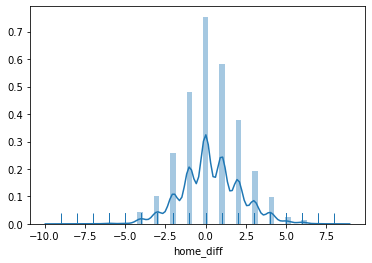

In [134]:
sns.distplot(df.home_diff, kde=True, rug=True);

In [135]:
df.home_match_result.value_counts().sum()

2948

In [136]:
df.home_match_result.value_counts()/df.home_match_result.value_counts().sum()

win     0.439281
lose    0.304274
draw    0.256445
Name: home_match_result, dtype: float64

Baseline model is 43.9% win, 30.4% lose and 25.6% draw from 2948 matches.

## Feature engineering and feature selection

The key point here is we do have extensive stats on the game statistics. However, we do not know a priori what these stats are. Further, we are going to assume these games are independent events, hence we are discounting prior results or form in this analysis. The only thing we are considering at this stage is the relative team and player strength on paper. Initially, only considering the team strengths based on FIFA 16 data.

In [137]:
for col in df.columns:
    print(col)

id
country_id
league_id
season
stage
match_date
match_api_id
home_team_api_id
away_team_api_id
home_team_goal
away_team_goal
home_player_X1
home_player_X2
home_player_X3
home_player_X4
home_player_X5
home_player_X6
home_player_X7
home_player_X8
home_player_X9
home_player_X10
home_player_X11
away_player_X1
away_player_X2
away_player_X3
away_player_X4
away_player_X5
away_player_X6
away_player_X7
away_player_X8
away_player_X9
away_player_X10
away_player_X11
home_player_Y1
home_player_Y2
home_player_Y3
home_player_Y4
home_player_Y5
home_player_Y6
home_player_Y7
home_player_Y8
home_player_Y9
home_player_Y10
home_player_Y11
away_player_Y1
away_player_Y2
away_player_Y3
away_player_Y4
away_player_Y5
away_player_Y6
away_player_Y7
away_player_Y8
away_player_Y9
away_player_Y10
away_player_Y11
home_player_1
home_player_2
home_player_3
home_player_4
home_player_5
home_player_6
home_player_7
home_player_8
home_player_9
home_player_10
home_player_11
away_player_1
away_player_2
away_player_3
away_play

In [138]:
features = ['home_buildUpPlaySpeed','home_buildUpPlayDribbling','home_buildUpPlayPassing','home_chanceCreationPassing','home_chanceCreationCrossing',
            'home_chanceCreationShooting','home_defencePressure','home_defenceAggression','home_defenceTeamWidth','away_buildUpPlaySpeed',
            'away_buildUpPlayDribbling','away_buildUpPlayPassing','away_chanceCreationPassing','away_chanceCreationCrossing','away_chanceCreationShooting',
            'away_defencePressure','away_defenceAggression','away_defenceTeamWidth']

In [139]:
X = df[features]
y = df.home_match_result

In [140]:
df[features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2948 entries, 0 to 2947
Data columns (total 18 columns):
home_buildUpPlaySpeed          2948 non-null int64
home_buildUpPlayDribbling      2948 non-null float64
home_buildUpPlayPassing        2948 non-null int64
home_chanceCreationPassing     2948 non-null int64
home_chanceCreationCrossing    2948 non-null int64
home_chanceCreationShooting    2948 non-null int64
home_defencePressure           2948 non-null int64
home_defenceAggression         2948 non-null int64
home_defenceTeamWidth          2948 non-null int64
away_buildUpPlaySpeed          2948 non-null int64
away_buildUpPlayDribbling      2948 non-null float64
away_buildUpPlayPassing        2948 non-null int64
away_chanceCreationPassing     2948 non-null int64
away_chanceCreationCrossing    2948 non-null int64
away_chanceCreationShooting    2948 non-null int64
away_defencePressure           2948 non-null int64
away_defenceAggression         2948 non-null int64
away_defenceTeamWidth 

At first glance in the diagonal of the pair plot, there is not enough separation between the features and the target variables with a lot of overlap. This suggests to me even before I start with the ML algorithms, it will probably fair poorly.

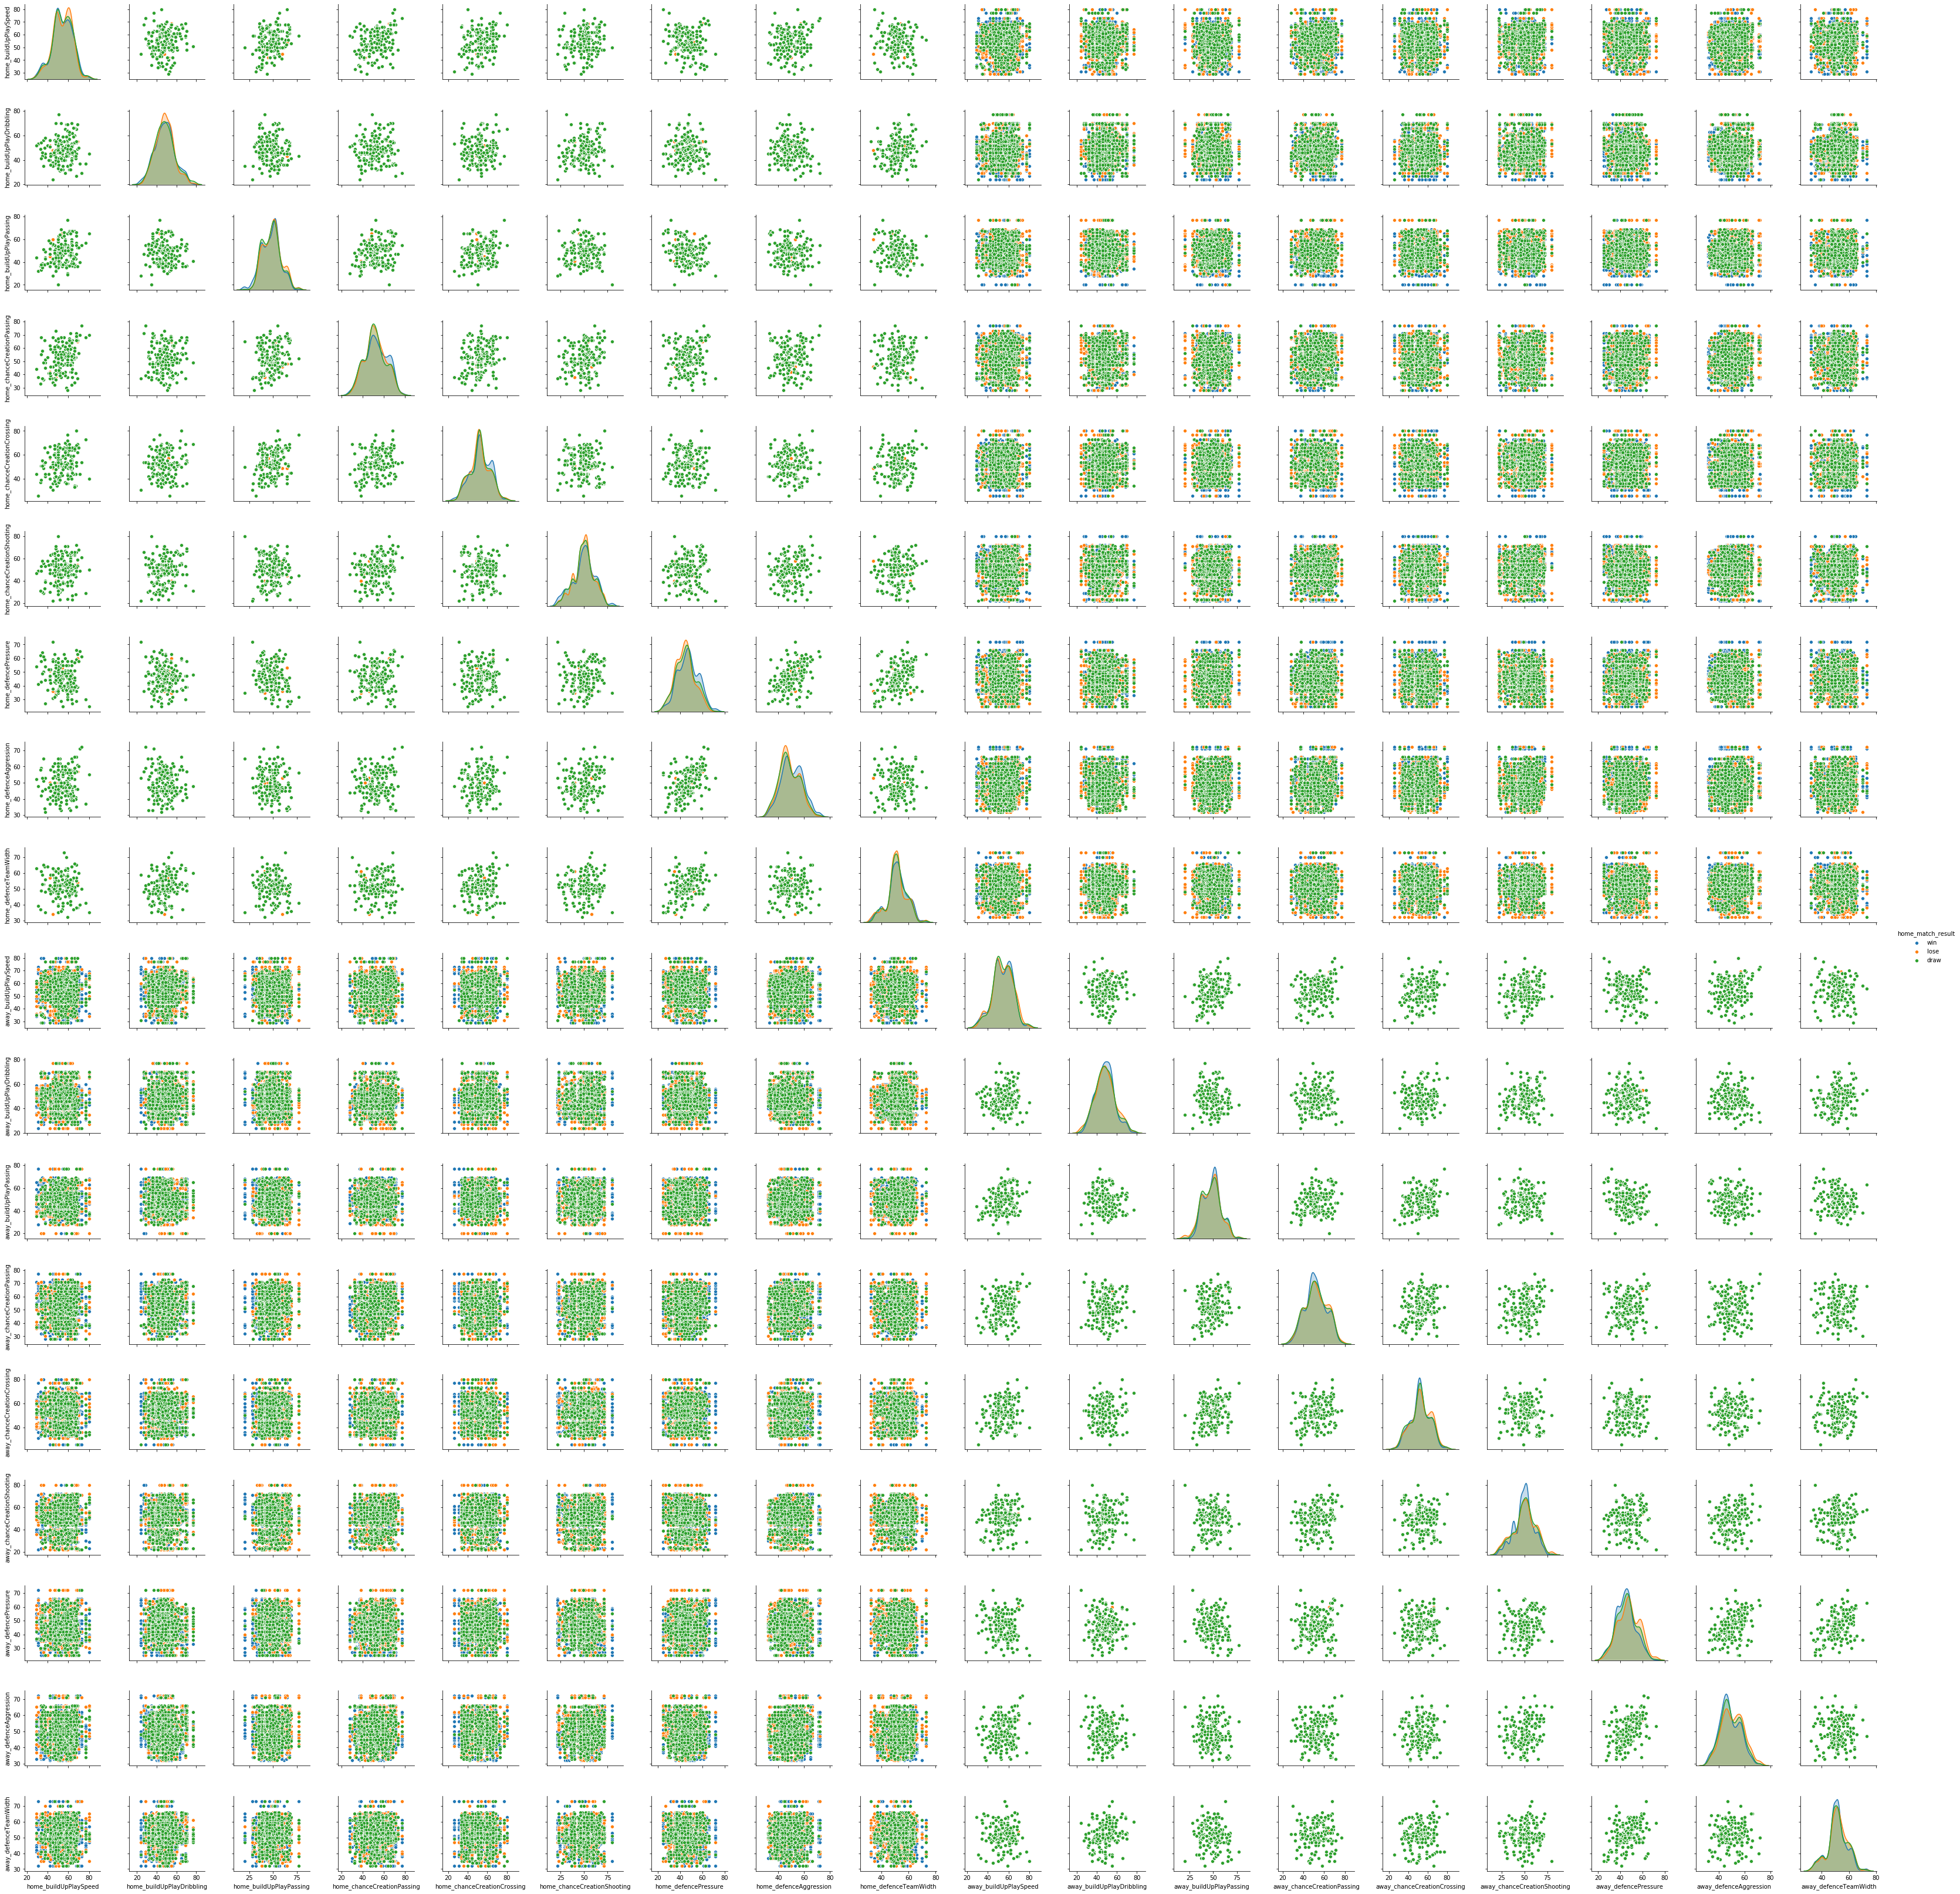

In [141]:
sns.pairplot(df,x_vars=features,y_vars=features,hue='home_match_result')

In [142]:
X_corr = X.corr()
X_corr

home_buildUpPlaySpeed  home_buildUpPlayDribbling  \
home_buildUpPlaySpeed                     1.000000                   0.073876   
home_buildUpPlayDribbling                 0.073876                   1.000000   
home_buildUpPlayPassing                   0.281307                  -0.028088   
home_chanceCreationPassing                0.321771                   0.034488   
home_chanceCreationCrossing               0.199164                   0.115507   
home_chanceCreationShooting               0.102404                   0.156696   
home_defencePressure                     -0.193118                  -0.055226   
home_defenceAggression                    0.132994                  -0.079539   
home_defenceTeamWidth                    -0.120206                   0.211869   
away_buildUpPlaySpeed                     0.058872                   0.057297   
away_buildUpPlayDribbling                 0.058384                   0.184601   
away_buildUpPlayPassing                  -0.025222                  -0.045291   
away_chanceCreationPassing                0.037221                   0.060603   
away_chanceCreationCrossing               0.007148                   0.052714   
away_chanceCreationShooting               0.040613                   0.111569   
away_defencePressure                     -0.041072                  -0.045019   
away_defenceAggression                    0.061874                   0.038423   
away_defenceTeamWidth                    -0.003938                   0.021900   

                             home_buildUpPlayPassing  \
home_buildUpPlaySpeed                       0.281307   
home_buildUpPlayDribbling                  -0.028088   
home_buildUpPlayPassing                     1.000000   
home_chanceCreationPassing                  0.247823   
home_chanceCreationCrossing                 0.280870   
home_chanceCreationShooting                -0.031486   
home_defencePressure                       -0.214233   
home_defenceAggression                     -0.074027   
home_defenceTeamWidth                      -0.103554   
away_buildUpPlaySpeed                      -0.027183   
away_buildUpPlayDribbling                  -0.045680   
away_buildUpPlayPassing                    -0.005514   
away_chanceCreationPassing                 -0.011632   
away_chanceCreationCrossing                -0.000601   
away_chanceCreationShooting                -0.031139   
away_defencePressure                        0.031954   
away_defenceAggression                     -0.000430   
away_defenceTeamWidth                      -0.003369   

                             home_chanceCreationPassing  \
home_buildUpPlaySpeed                          0.321771   
home_buildUpPlayDribbling                      0.034488   
home_buildUpPlayPassing                        0.247823   
home_chanceCreationPassing                     1.000000   
home_chanceCreationCrossing                    0.262920   
home_chanceCreationShooting                    0.205900   
home_defencePressure                           0.047897   
home_defenceAggression                         0.094128   
home_defenceTeamWidth                         -0.067871   
away_buildUpPlaySpeed                          0.037090   
away_buildUpPlayDribbling                      0.059811   
away_buildUpPlayPassing                       -0.012600   
away_chanceCreationPassing                     0.050154   
away_chanceCreationCrossing                    0.024419   
away_chanceCreationShooting                    0.039404   
away_defencePressure                           0.010779   
away_defenceAggression                         0.094584   
away_defenceTeamWidth                         -0.007514   

                             home_chanceCreationCrossing  \
home_buildUpPlaySpeed                           0.199164   
home_buildUpPlayDribbling                       0.115507   
home_buildUpPlayPassing                         0.280870   
home_chanceCreationPassing                      0.262920   
ho

It is interesting to note looking in the bottom left corner of the correlation heat map, there is very little correlation between the home and the away variables.

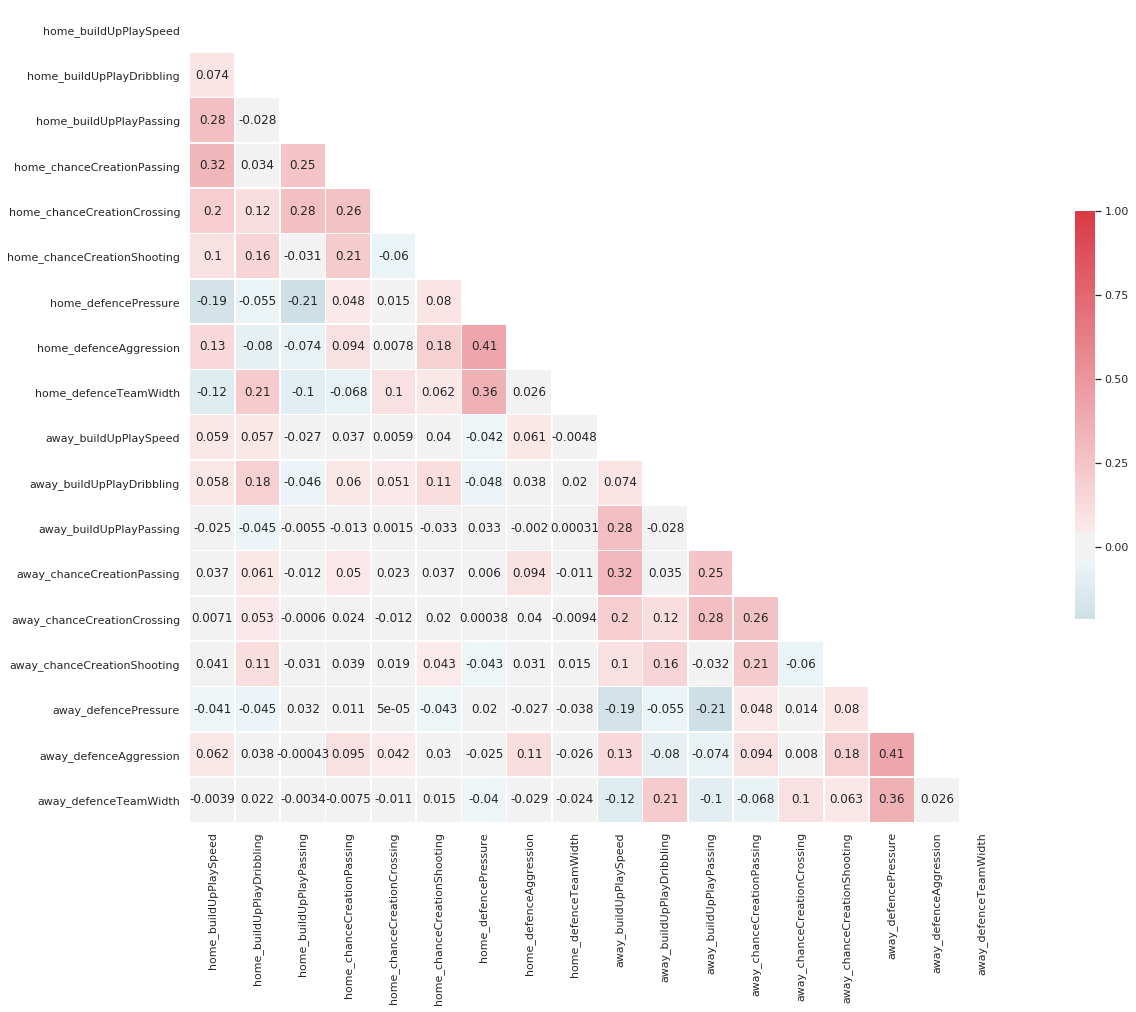

In [143]:
# Copied code from seaborn examples
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(X_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(X_corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show();

## Multivariable classification

Will use 18 features (9 home team attributes + 9 away team attributes) and target variable is to predict the outcome 'win','lose' or 'draw' using multivariable classification algorithms.

In [144]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [145]:
LR = LogisticRegression(max_iter=1000,multi_class='multinomial')
LRCV = LogisticRegressionCV(max_iter=1000,multi_class='multinomial')
RC = RidgeClassifier()
RCCV = RidgeClassifierCV()
BNB = BernoulliNB()
GNB = GaussianNB()
DTC = DecisionTreeClassifier(random_state=1000)
LSVC = LinearSVC(max_iter=10000,multi_class='crammer_singer')
MLPC = MLPClassifier()
RFC = RandomForestClassifier(random_state=1000)

In [146]:
DTC_4 = DecisionTreeClassifier(random_state=1000,max_depth=4)
DTC_4.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1000, splitter='best')

In [147]:
LR_fit = LR.fit(X_train,y_train)
LRCV_fit = LRCV.fit(X_train,y_train)
RC_fit = RC.fit(X_train,y_train)
RCCV_fit = RCCV.fit(X_train,y_train)
BNB_fit = BNB.fit(X_train,y_train)
GNB_fit = GNB.fit(X_train,y_train)
DTC_fit = DTC.fit(X_train,y_train)
LSVC_fit = LSVC.fit(X_train,y_train)
MLPC_fit = MLPC.fit(X_train,y_train)
RFC_fit = RFC.fit(X_train,y_train)

/home/pug/data_science/DSIA/VE/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [148]:
y.unique()

array(['win', 'lose', 'draw'], dtype=object)

In [149]:
ticks = ['draw','lose','win']

In [150]:
def show_summary_report(actual, prediction):

    #if isinstance(actual, pd.Series):
    #    actual = actual.values.astype(int)
    #prediction = prediction.astype(int)

    accuracy_ = accuracy_score(actual, prediction)
    precision_ = precision_score(actual, prediction,average=None)
    recall_ = recall_score(actual, prediction,average=None)

    print('Accuracy : ', accuracy_)
    print('Precision: ', precision_)
    print('Recall   : ', recall_)   
    print('Labels   : ', ticks)
    print('-' * 107)
    #print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')

    # Confusion Matrix
    mat = confusion_matrix(actual, prediction)

    # Precision/Recall
    #precision, recall, _ = precision_recall_curve(actual, prediction)
    #average_precision = average_precision_score(actual, prediction)
    
    # Compute ROC curve and ROC area
    #fpr, tpr, _ = roc_curve(actual, prediction)
    #roc_auc = auc(fpr, tpr)


    # plot
    fig, ax = plt.subplots(1, 1, figsize = (10, 10))
    fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

    # Confusion Matrix
    sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Blues', ax = ax,xticklabels=ticks,yticklabels=ticks)

    ax.set_title('Confusion Matrix')
    ax.set_xlabel('True label')
    ax.set_ylabel('Predicted label')
    '''
    # Precision/Recall
    step_kwargs = {'step': 'post'}
    ax[1].step(recall, precision, color = 'b', alpha = 0.2, where = 'post')
    ax[1].fill_between(recall, precision, alpha = 0.2, color = 'b', **step_kwargs)
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('2-class Precision-Recall curve')
    '''
    '''
    # ROC
    ax[2].plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (AUC = %0.2f)' % roc_auc)
    ax[2].plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    ax[2].set_xlim([0.0, 1.0])
    ax[2].set_ylim([0.0, 1.0])
    ax[2].set_xlabel('False Positive Rate')
    ax[2].set_ylabel('True Positive Rate')
    ax[2].set_title('Receiver Operating Characteristic')
    ax[2].legend(loc = 'lower right')
    '''

    plt.show()
    
    return (accuracy_, precision_, recall_)

***********************
* Logistic Regression *
***********************
Accuracy :  0.4770992366412214
Precision:  [0.44444444 0.4295416  0.49318182]
Recall   :  [0.00677966 0.35384615 0.82431149]
Labels   :  ['draw', 'lose', 'win']
-----------------------------------------------------------------------------------------------------------


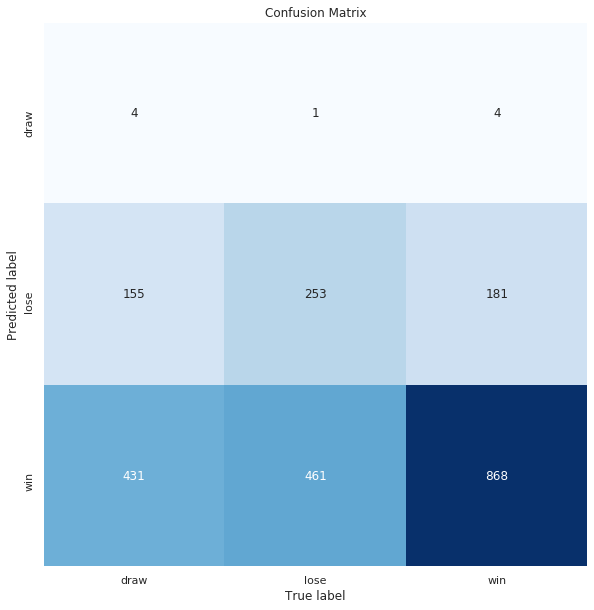


**************************
* Logistic Regression CV *
**************************
Accuracy :  0.4758269720101781
Precision:  [1.         0.43100189 0.48851204]
Recall   :  [0.00169492 0.31888112 0.84805318]
Labels   :  ['draw', 'lose', 'win']
-----------------------------------------------------------------------------------------------------------


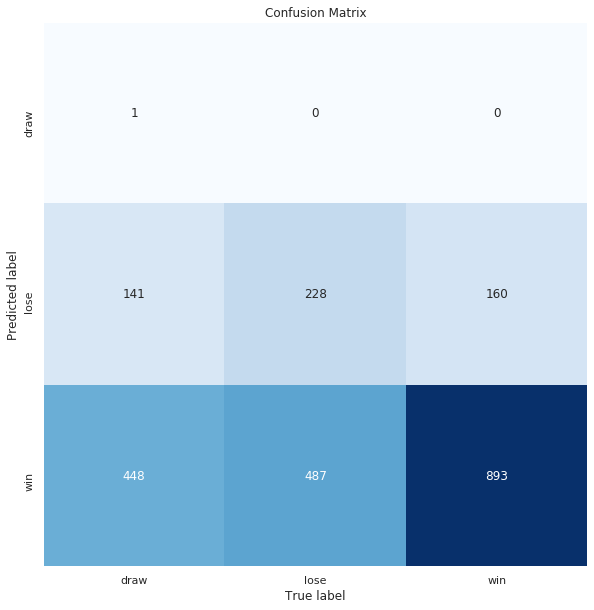


********************
* Ridge Classifier *
********************
Accuracy :  0.47497879558948264
Precision:  [0.66666667 0.421875   0.49155405]
Recall   :  [0.00677966 0.33986014 0.82905983]
Labels   :  ['draw', 'lose', 'win']
-----------------------------------------------------------------------------------------------------------


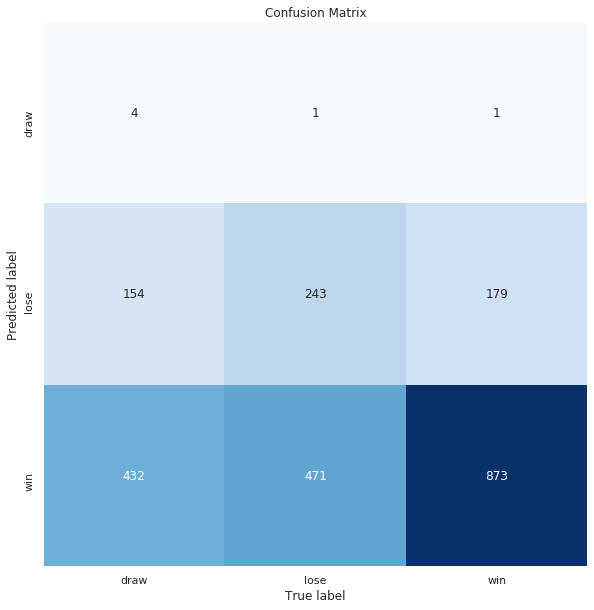


***********************
* Ridge Classifier CV *
***********************
Accuracy :  0.47497879558948264
Precision:  [0.66666667 0.421875   0.49155405]
Recall   :  [0.00677966 0.33986014 0.82905983]
Labels   :  ['draw', 'lose', 'win']
-----------------------------------------------------------------------------------------------------------


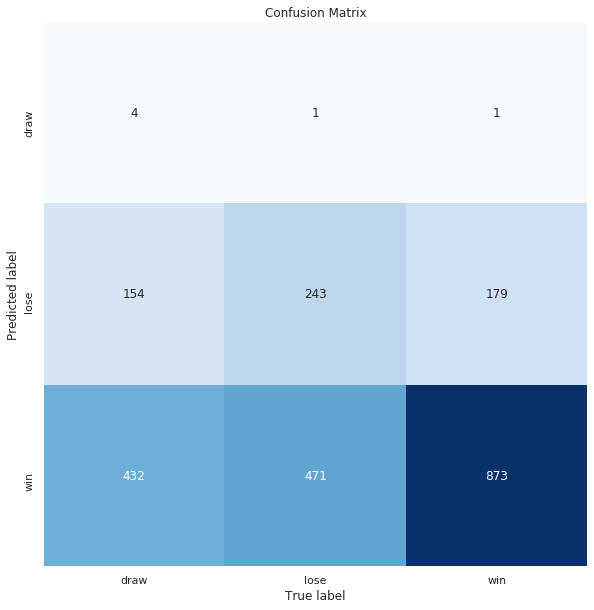


***************
* BernoulliNB *
***************
Accuracy :  0.44656488549618323
Precision:  [0.         0.         0.44656489]
Recall   :  [0. 0. 1.]
Labels   :  ['draw', 'lose', 'win']
-----------------------------------------------------------------------------------------------------------


/home/pug/data_science/DSIA/VE/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


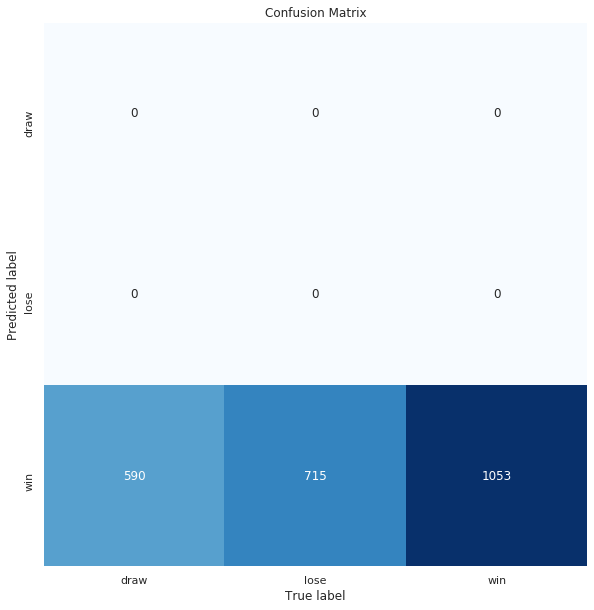


**************
* GaussianNB *
**************
Accuracy :  0.48388464800678543
Precision:  [0.3364486  0.4388587  0.51617162]
Recall   :  [0.06101695 0.45174825 0.74264008]
Labels   :  ['draw', 'lose', 'win']
-----------------------------------------------------------------------------------------------------------


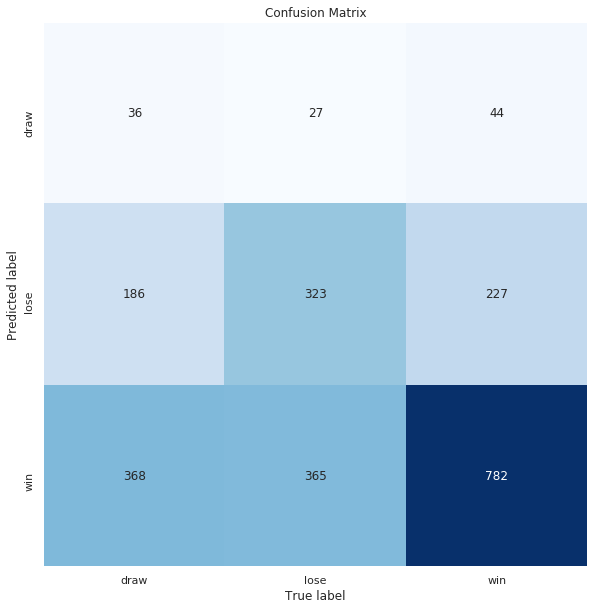


****************************
* Decision Tree Classifier *
****************************
Accuracy :  0.9775233248515691
Precision:  [0.95153473 0.96944444 0.99901865]
Recall   :  [0.99830508 0.97622378 0.96676163]
Labels   :  ['draw', 'lose', 'win']
-----------------------------------------------------------------------------------------------------------


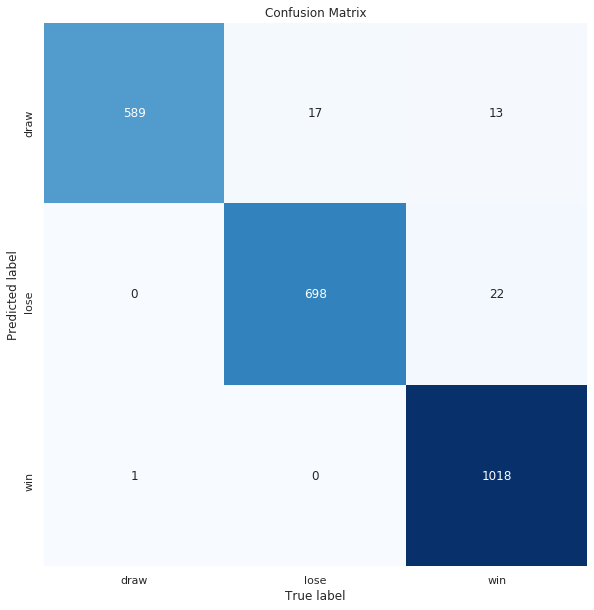


**************
* Linear SVC *
**************
Accuracy :  0.4079728583545377
Precision:  [0.29333333 0.33933002 0.585693  ]
Recall   :  [0.03728814 0.76503497 0.37321937]
Labels   :  ['draw', 'lose', 'win']
-----------------------------------------------------------------------------------------------------------


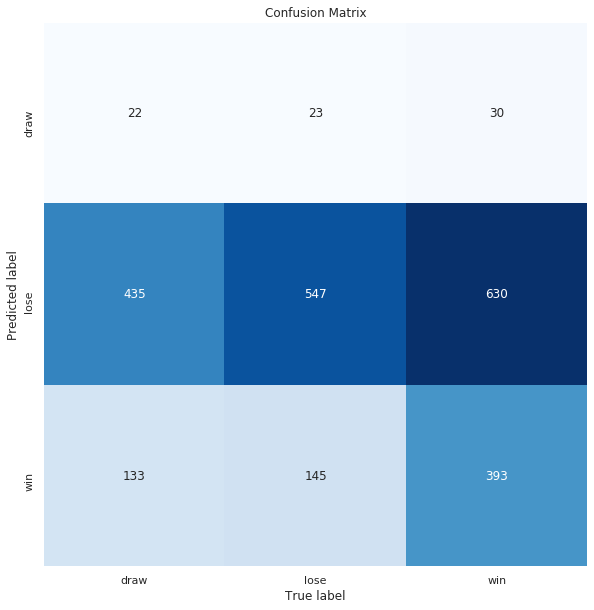


******************
* MLP Classifier *
******************
Accuracy :  0.48346055979643765
Precision:  [0.33101045 0.48603352 0.50846468]
Recall   :  [0.16101695 0.24335664 0.82716049]
Labels   :  ['draw', 'lose', 'win']
-----------------------------------------------------------------------------------------------------------


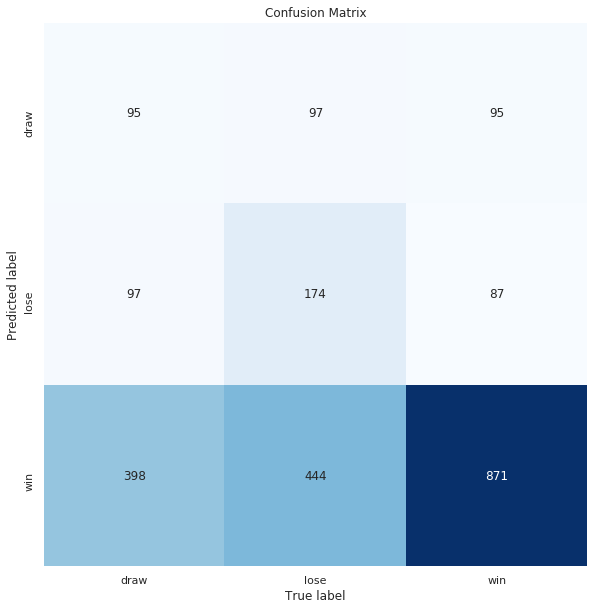


****************************
* Random Forest Classifier *
****************************
Accuracy :  0.9775233248515691
Precision:  [0.98272884 0.96814404 0.98107852]
Recall   :  [0.96440678 0.97762238 0.98480532]
Labels   :  ['draw', 'lose', 'win']
-----------------------------------------------------------------------------------------------------------


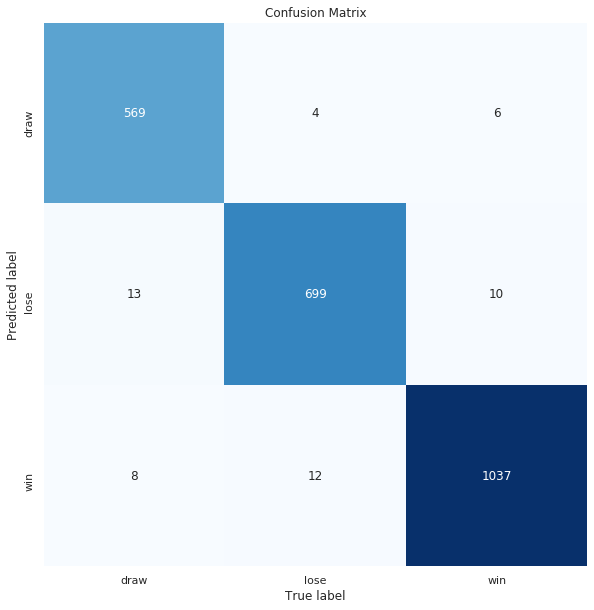

In [151]:
# Keep the results in a dataframe
results = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall'])

models = ['Logistic Regression','Logistic Regression CV','Ridge Classifier','Ridge Classifier CV','BernoulliNB','GaussianNB','Decision Tree Classifier','Linear SVC','MLP Classifier','Random Forest Classifier']
for i, m in enumerate([LR,LRCV,RC,RCCV,BNB,GNB,DTC,LSVC,MLPC,RFC]):
    print('*' * (len(models[i]) + 4))
    print('* %s *' % models[i])
    print('*' * (len(models[i]) + 4))
    predictions = m.predict(X_train)
    # show the report
    accuracy_, precision_, recall_ = show_summary_report(y_train, predictions)
    # keep the results
    results.loc[i] = {'Model': models[i], 
                      'Accuracy': accuracy_, 
                      'Precision': precision_,
                      'Recall': recall_}
    print()

In [152]:
predictions

array(['lose', 'lose', 'lose', ..., 'win', 'win', 'lose'], dtype=object)

In [153]:
confusion_matrix(y_train, predictions)

array([[ 569,   13,    8],
       [   4,  699,   12],
       [   6,   10, 1037]])

In [154]:
y_train.value_counts()

win     1053
lose     715
draw     590
Name: home_match_result, dtype: int64

## Analysing the models

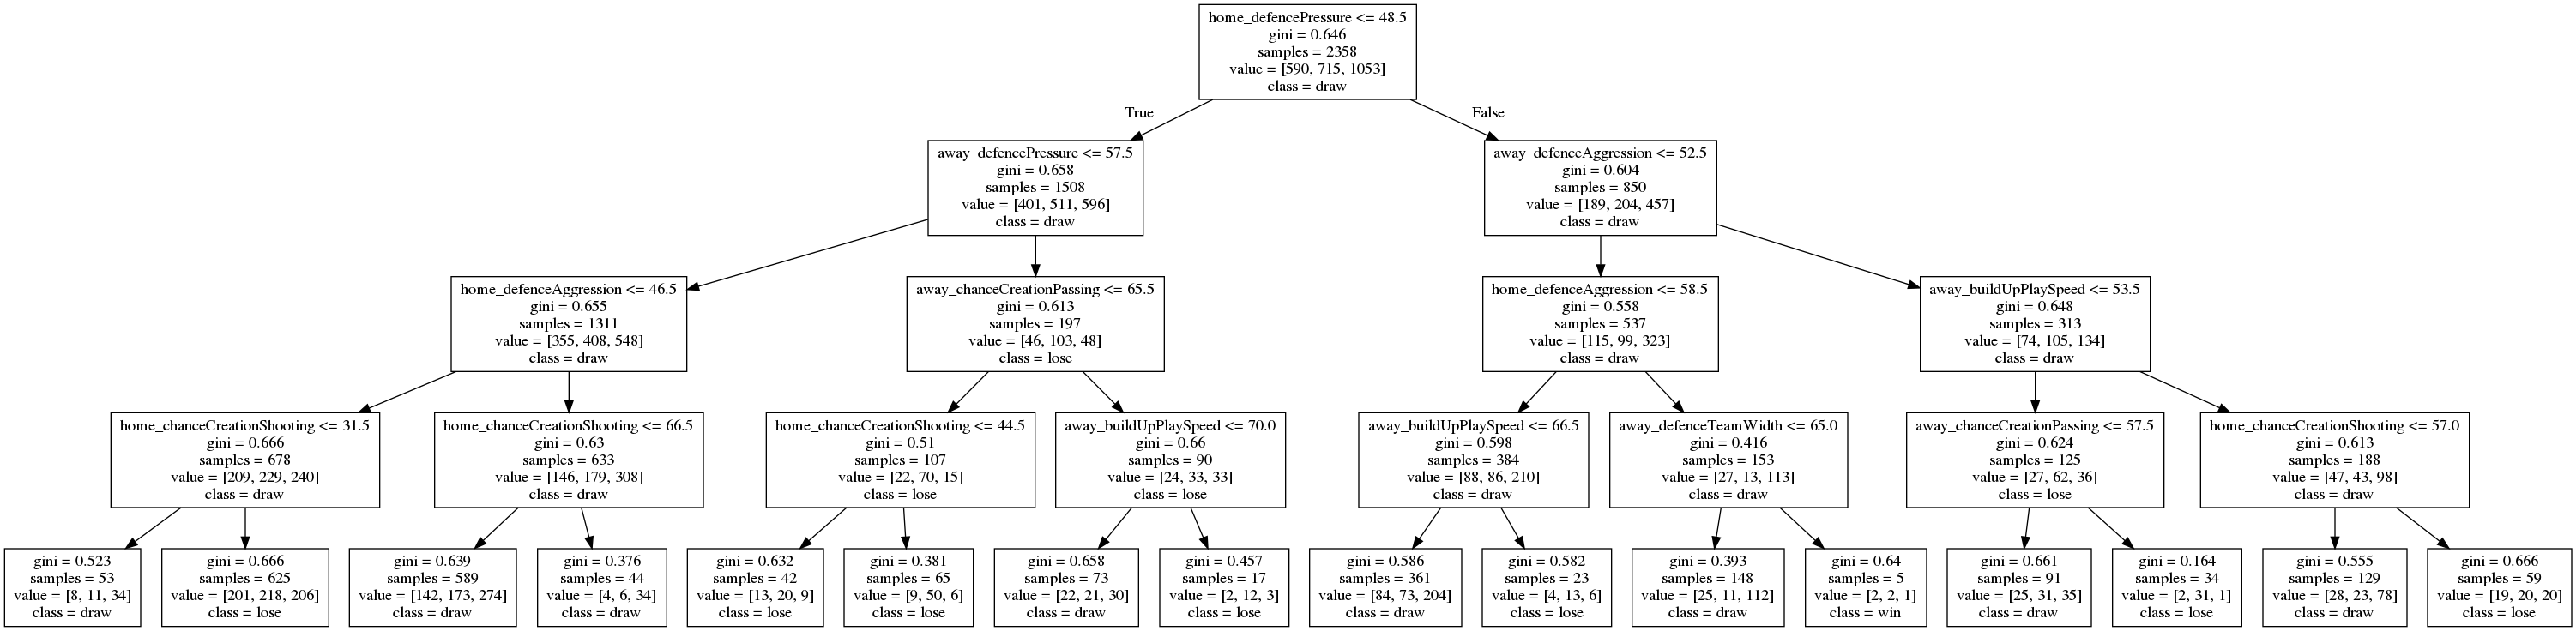

In [155]:
# Create DOT data
dot_data = tree.export_graphviz(DTC_4, out_file=None, 
                                feature_names=features,  
                                class_names=y.unique())

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

In [156]:
# Create PDF
graph.write_pdf("DTC4.pdf")

# Create PNG
graph.write_png("DTC4.png")

True

In [157]:
DTC.feature_importances_

array([0.05479815, 0.05286257, 0.04039601, 0.04988165, 0.04124684,
       0.06240322, 0.04674535, 0.05174037, 0.04636571, 0.05002465,
       0.05906331, 0.0622031 , 0.0634382 , 0.05227525, 0.05734782,
       0.08356189, 0.06596529, 0.05968062])

In [158]:
RFC.feature_importances_

array([0.0518837 , 0.05585574, 0.05615438, 0.05273047, 0.05472918,
       0.05871503, 0.0608922 , 0.05928847, 0.05277016, 0.05419145,
       0.05484134, 0.05467803, 0.05347316, 0.05325622, 0.05786936,
       0.06086228, 0.05652937, 0.05127945])

In [159]:
features

['home_buildUpPlaySpeed',
 'home_buildUpPlayDribbling',
 'home_buildUpPlayPassing',
 'home_chanceCreationPassing',
 'home_chanceCreationCrossing',
 'home_chanceCreationShooting',
 'home_defencePressure',
 'home_defenceAggression',
 'home_defenceTeamWidth',
 'away_buildUpPlaySpeed',
 'away_buildUpPlayDribbling',
 'away_buildUpPlayPassing',
 'away_chanceCreationPassing',
 'away_chanceCreationCrossing',
 'away_chanceCreationShooting',
 'away_defencePressure',
 'away_defenceAggression',
 'away_defenceTeamWidth']

***********************
* Logistic Regression *
***********************
Accuracy :  0.4457627118644068
Precision:  [0.         0.43939394 0.44857768]
Recall   :  [0.         0.31868132 0.84710744]
Labels   :  ['draw', 'lose', 'win']
-----------------------------------------------------------------------------------------------------------


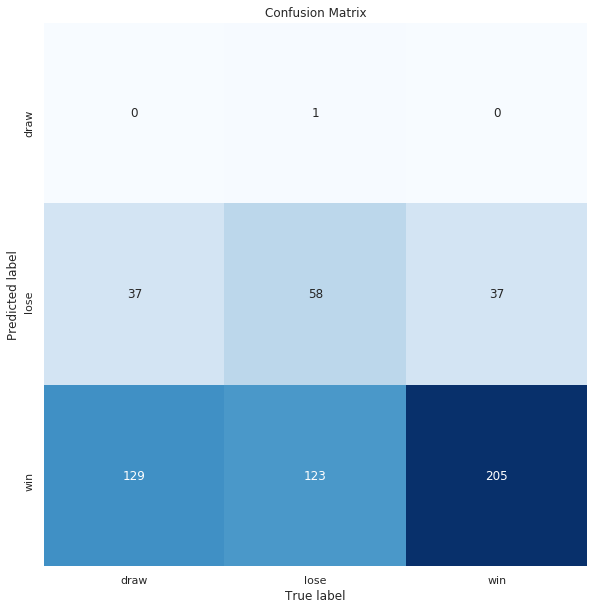


**************************
* Logistic Regression CV *
**************************
Accuracy :  0.4423728813559322
Precision:  [0.         0.43697479 0.44373673]
Recall   :  [0.         0.28571429 0.86363636]
Labels   :  ['draw', 'lose', 'win']
-----------------------------------------------------------------------------------------------------------


/home/pug/data_science/DSIA/VE/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


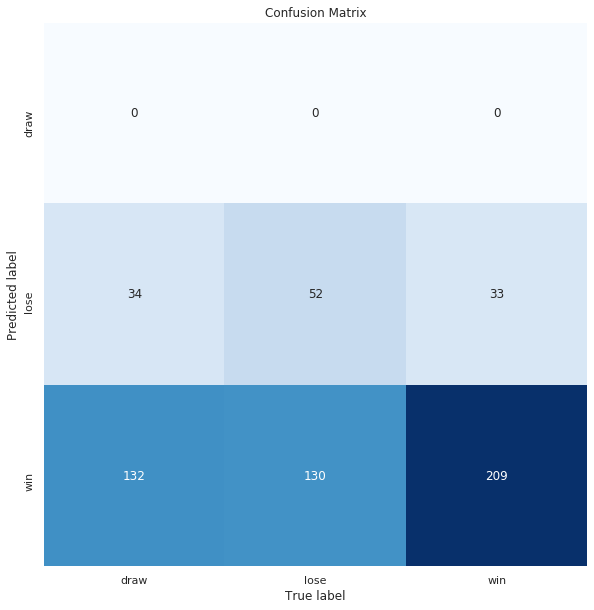


********************
* Ridge Classifier *
********************
Accuracy :  0.45084745762711864
Precision:  [0.         0.45669291 0.45021645]
Recall   :  [0.         0.31868132 0.85950413]
Labels   :  ['draw', 'lose', 'win']
-----------------------------------------------------------------------------------------------------------


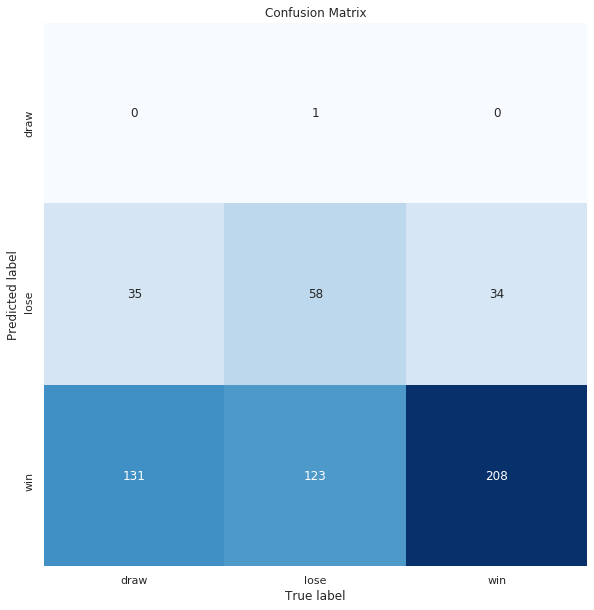


***********************
* Ridge Classifier CV *
***********************
Accuracy :  0.45084745762711864
Precision:  [0.         0.45669291 0.45021645]
Recall   :  [0.         0.31868132 0.85950413]
Labels   :  ['draw', 'lose', 'win']
-----------------------------------------------------------------------------------------------------------


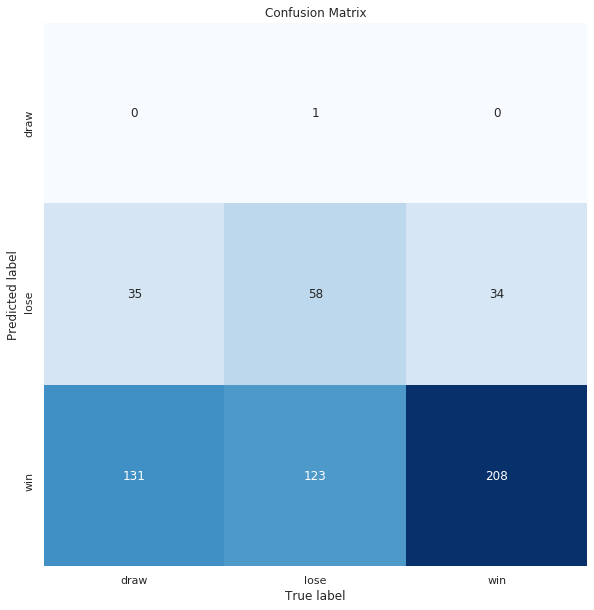


***************
* BernoulliNB *
***************
Accuracy :  0.4101694915254237
Precision:  [0.         0.         0.41016949]
Recall   :  [0. 0. 1.]
Labels   :  ['draw', 'lose', 'win']
-----------------------------------------------------------------------------------------------------------


/home/pug/data_science/DSIA/VE/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


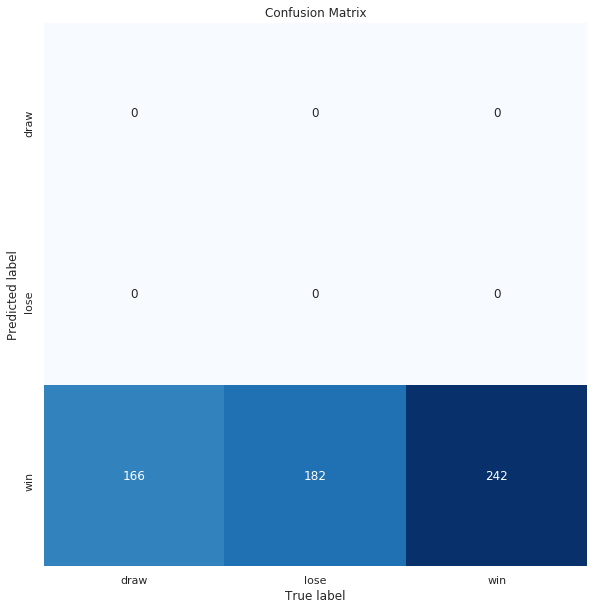


**************
* GaussianNB *
**************
Accuracy :  0.45084745762711864
Precision:  [0.2        0.42857143 0.47692308]
Recall   :  [0.03012048 0.41208791 0.76859504]
Labels   :  ['draw', 'lose', 'win']
-----------------------------------------------------------------------------------------------------------


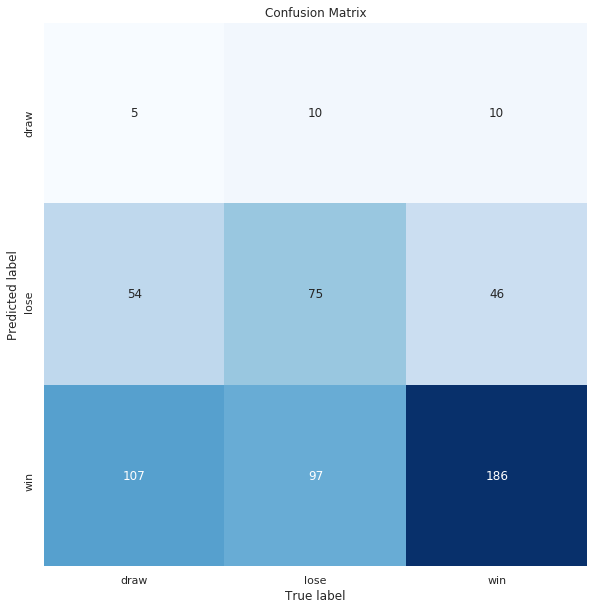


****************************
* Decision Tree Classifier *
****************************
Accuracy :  0.3847457627118644
Precision:  [0.2208589  0.38787879 0.48473282]
Recall   :  [0.21686747 0.35164835 0.52479339]
Labels   :  ['draw', 'lose', 'win']
-----------------------------------------------------------------------------------------------------------


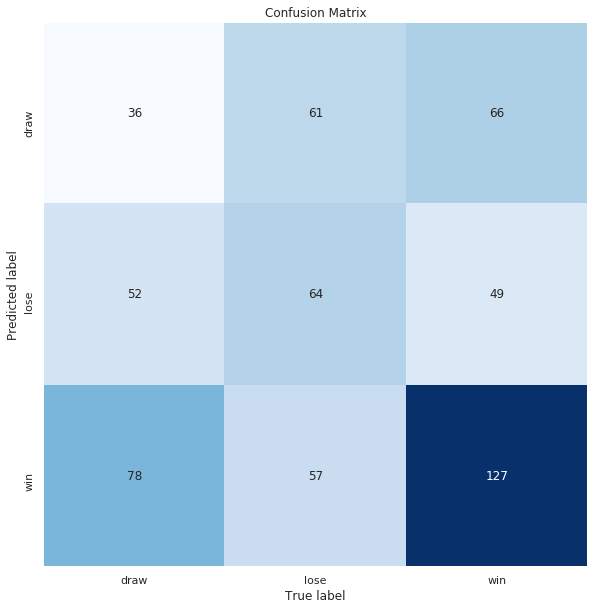


**************
* Linear SVC *
**************
Accuracy :  0.4016949152542373
Precision:  [0.25       0.35141509 0.56849315]
Recall   :  [0.03012048 0.81868132 0.34297521]
Labels   :  ['draw', 'lose', 'win']
-----------------------------------------------------------------------------------------------------------


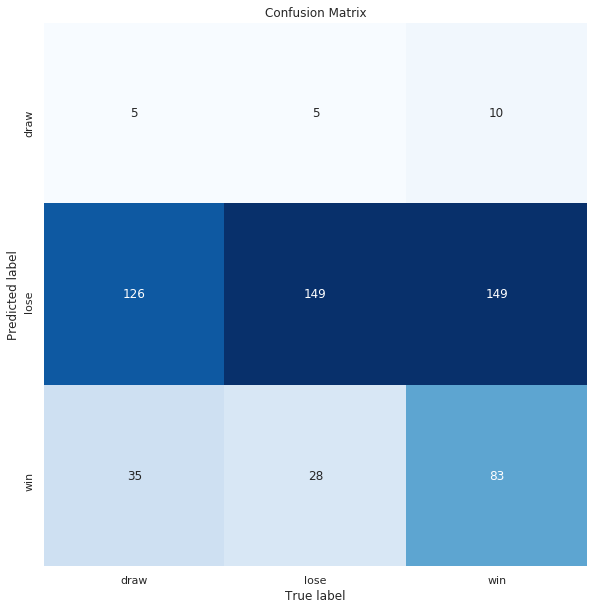


******************
* MLP Classifier *
******************
Accuracy :  0.43050847457627117
Precision:  [0.32307692 0.3875     0.45393258]
Recall   :  [0.12650602 0.17032967 0.83471074]
Labels   :  ['draw', 'lose', 'win']
-----------------------------------------------------------------------------------------------------------


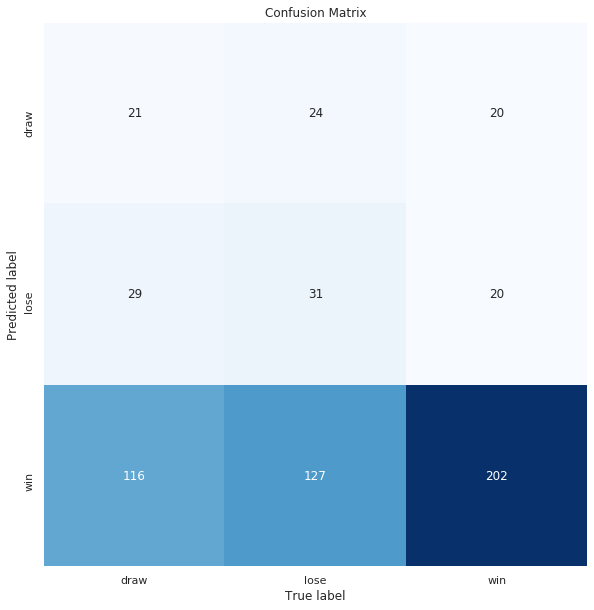


****************************
* Random Forest Classifier *
****************************
Accuracy :  0.44745762711864406
Precision:  [0.30434783 0.45       0.4852071 ]
Recall   :  [0.1686747  0.3956044  0.67768595]
Labels   :  ['draw', 'lose', 'win']
-----------------------------------------------------------------------------------------------------------


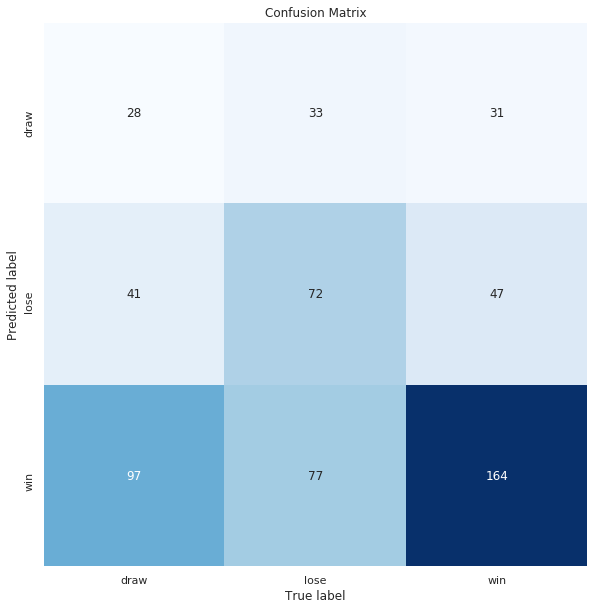

In [160]:
# Keep the results in a dataframe
results = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall'])

models = ['Logistic Regression','Logistic Regression CV','Ridge Classifier','Ridge Classifier CV','BernoulliNB','GaussianNB','Decision Tree Classifier','Linear SVC','MLP Classifier','Random Forest Classifier']
for i, m in enumerate([LR,LRCV,RC,RCCV,BNB,GNB,DTC,LSVC,MLPC,RFC]):
    print('*' * (len(models[i]) + 4))
    print('* %s *' % models[i])
    print('*' * (len(models[i]) + 4))
    predictions = m.predict(X_test)
    # show the report
    accuracy_, precision_, recall_ = show_summary_report(y_test, predictions)
    # keep the results
    results.loc[i] = {'Model': models[i], 
                      'Accuracy': accuracy_, 
                      'Precision': precision_,
                      'Recall': recall_}
    print()

## Overfitting

It is clear that random forest and decision tree is overfitted on the training set and performing poorly on the testing set. All the other algorithms barely managed to improve on the 43% win baseline and were weak predictors of the outcome of the match. Will attempt bagging ensemble methods to counter this overfitting problem.

In [161]:
clf1 = DecisionTreeClassifier(criterion = 'entropy', max_depth = 2,random_state = 42)

In [162]:
bagging1 = BaggingClassifier(
    base_estimator = clf1,
    n_estimators = 1000,
    max_samples = 0.8,
    max_features = 0.8)

In [163]:
bagging1.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='entropy',
                                                        max_depth=2,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=42,
  

In [164]:
print(bagging1.score(X_train,y_train))

0.47921967769296014


In [165]:
print(bagging1.score(X_test,y_test))

0.44745762711864406


## Analysis

With the exception of Decision Tree and Random Forest, all the models trained very poorly to the dataset with accuracy in the mid 40s for all the models. However, for Decision Tree and Random Forest the training accuracy was greater than 97%. The caveat here though is it overfitted the training set. For the testing set, it was clear with Decision Tree and Random Forest did poorly with testing accuracy of around 38% and 44% respectively. The other models were still in the 40s in terms of accuracy. 

# Change of approach from classification to regression

## Outline

There are a few things to note, the features selected were both away and home team attributes. It may be worth looking into the contrast between the home team and the away team stats. Given the difference between the team attributes, does this build a picture on how strong the teams are on paper, and hence the probability a win, loss or draw is predicted using the goal difference as the target variable. Let's deep dive into this and see if our results improve.

## Feature engineering

In [166]:
df.columns

Index(['id', 'country_id', 'league_id', 'season', 'stage', 'match_date',
       'match_api_id', 'home_team_api_id', 'away_team_api_id',
       'home_team_goal',
       ...
       'away_chanceCreationPositioningClass', 'away_defencePressure',
       'away_defencePressureClass', 'away_defenceAggression',
       'away_defenceAggressionClass', 'away_defenceTeamWidth',
       'away_defenceTeamWidthClass', 'away_defenceDefenderLineClass',
       'home_match_result', 'home_diff'],
      dtype='object', length=165)

In [167]:
features

['home_buildUpPlaySpeed',
 'home_buildUpPlayDribbling',
 'home_buildUpPlayPassing',
 'home_chanceCreationPassing',
 'home_chanceCreationCrossing',
 'home_chanceCreationShooting',
 'home_defencePressure',
 'home_defenceAggression',
 'home_defenceTeamWidth',
 'away_buildUpPlaySpeed',
 'away_buildUpPlayDribbling',
 'away_buildUpPlayPassing',
 'away_chanceCreationPassing',
 'away_chanceCreationCrossing',
 'away_chanceCreationShooting',
 'away_defencePressure',
 'away_defenceAggression',
 'away_defenceTeamWidth']

In [168]:
df['homediff_buildUpPlaySpeed'] = df['home_buildUpPlaySpeed']-df['away_buildUpPlaySpeed']
df['homediff_buildUpPlayDribbling'] = df['home_buildUpPlayDribbling']-df['away_buildUpPlayDribbling']
df['homediff_buildUpPlayPassing'] = df['home_buildUpPlayPassing'] - df['away_buildUpPlayPassing']
df['homediff_chanceCreationPassing'] = df['home_chanceCreationPassing'] - df['away_chanceCreationPassing']
df['homediff_chanceCreationCrossing'] = df['home_chanceCreationCrossing'] - df['away_chanceCreationCrossing'] 
df['homediff_chanceCreationShooting'] = df['home_chanceCreationShooting'] - df['away_chanceCreationShooting']
df['homediff_defencePressure'] = df['home_defencePressure'] - df['away_defencePressure']
df['homediff_defenceAggression'] = df['home_defenceAggression'] - df['away_defenceAggression'] 
df['homediff_defenceTeamWidth'] = df['home_defenceTeamWidth'] - df['away_defenceTeamWidth']

In [169]:
diff_col = {'homediff_buildUpPlaySpeed':'diff_bupSpeed',
'homediff_buildUpPlayDribbling':'diff_bupDribbling',
'homediff_buildUpPlayPassing':'diff_bupPassing',
'homediff_chanceCreationPassing':'diff_ccPassing',
'homediff_chanceCreationCrossing':'diff_ccCrossing',
'homediff_chanceCreationShooting':'diff_ccShooting',
'homediff_defencePressure':'diff_dPresure',
'homediff_defenceAggression':'diff_dAgg',
'homediff_defenceTeamWidth':'diff_dTWidth'}

In [170]:
df = df.rename(columns=diff_col)
 

In [171]:
df.columns

Index(['id', 'country_id', 'league_id', 'season', 'stage', 'match_date',
       'match_api_id', 'home_team_api_id', 'away_team_api_id',
       'home_team_goal',
       ...
       'home_diff', 'diff_bupSpeed', 'diff_bupDribbling', 'diff_bupPassing',
       'diff_ccPassing', 'diff_ccCrossing', 'diff_ccShooting', 'diff_dPresure',
       'diff_dAgg', 'diff_dTWidth'],
      dtype='object', length=174)

In [172]:
reg_features = ['diff_bupSpeed',
'diff_bupDribbling',
'diff_bupPassing',
'diff_ccPassing',
'diff_ccCrossing',
'diff_ccShooting',
'diff_dPresure',
'diff_dAgg',
'diff_dTWidth']

In [173]:
reg_vars = ['diff_bupSpeed',
'diff_bupDribbling',
'diff_bupPassing',
'diff_ccPassing',
'diff_ccCrossing',
'diff_ccShooting',
'diff_dPresure',
'diff_dAgg',
'diff_dTWidth',
 'home_diff']

In [174]:
print(reg_vars)

['diff_bupSpeed', 'diff_bupDribbling', 'diff_bupPassing', 'diff_ccPassing', 'diff_ccCrossing', 'diff_ccShooting', 'diff_dPresure', 'diff_dAgg', 'diff_dTWidth', 'home_diff']


In [175]:
Xreg = df[reg_features]
y = df.home_diff

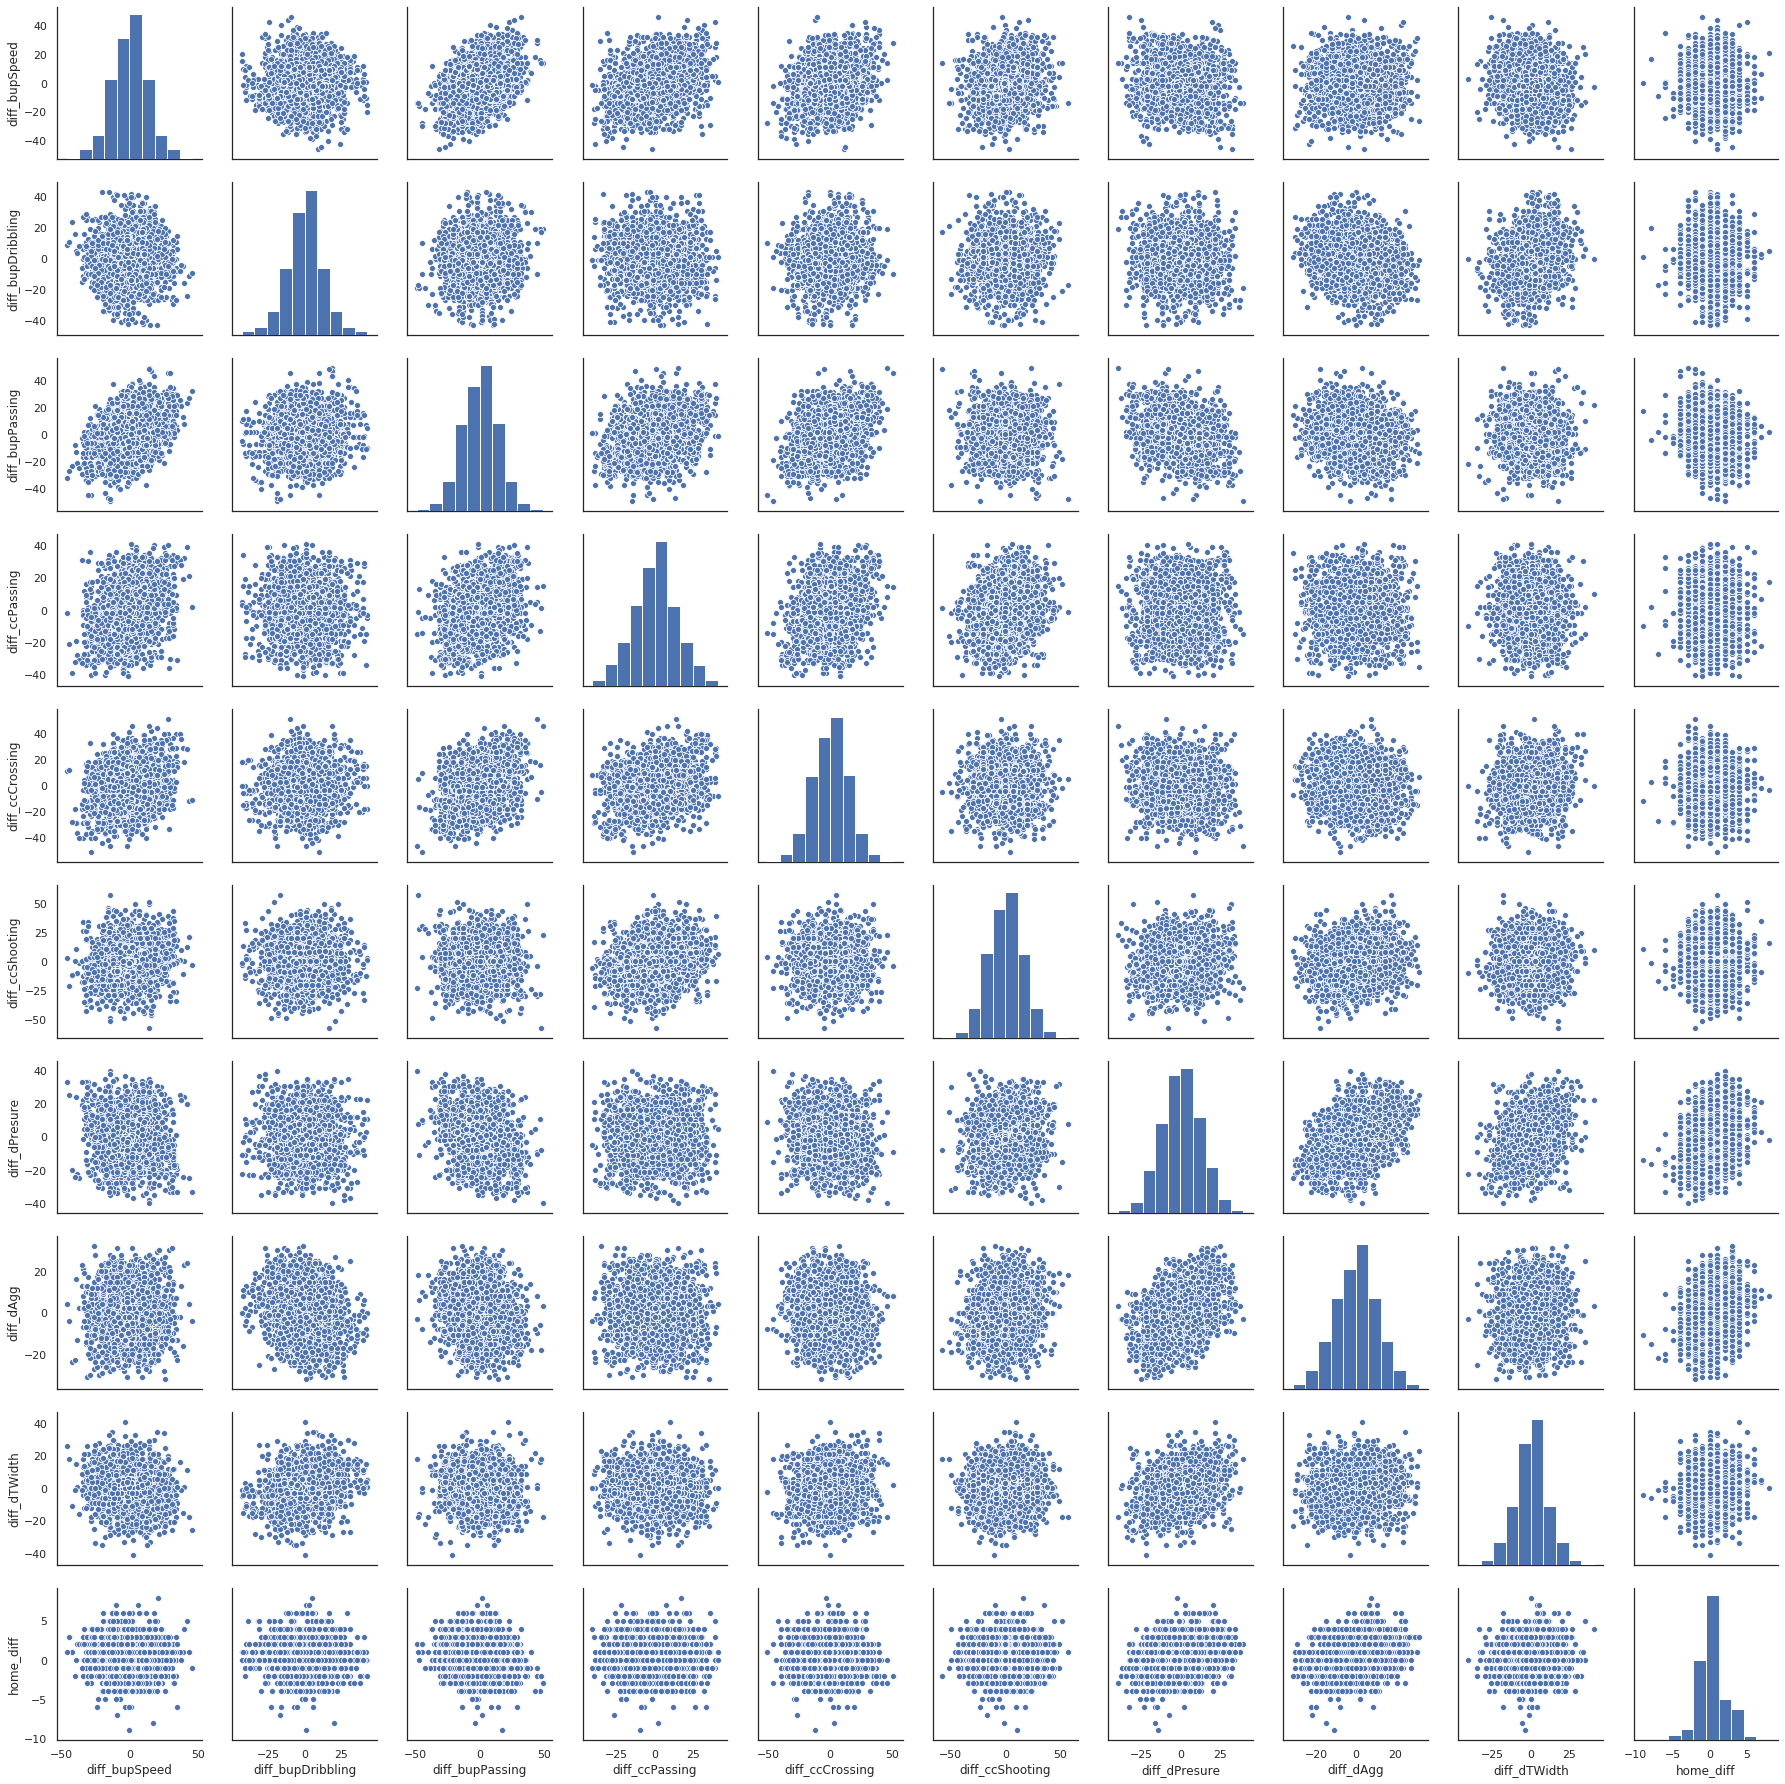

In [176]:
sns.pairplot(df,x_vars=reg_vars,y_vars=reg_vars)

In [177]:
reg_corr = df[reg_vars].corr()
reg_corr

diff_bupSpeed  diff_bupDribbling  diff_bupPassing  \
diff_bupSpeed           1.000000           0.018330         0.316435   
diff_bupDribbling       0.018330           1.000000         0.019365   
diff_bupPassing         0.316435           0.019365         1.000000   
diff_ccPassing          0.300876          -0.029103         0.265679   
diff_ccCrossing         0.197504           0.070313         0.277854   
diff_ccShooting         0.064966           0.052602         0.000190   
diff_dPresure          -0.157511          -0.009781        -0.248405   
diff_dAgg               0.078237          -0.138277        -0.076772   
diff_dTWidth           -0.118148           0.208702        -0.100514   
home_diff              -0.018132           0.001277        -0.122601   

                   diff_ccPassing  diff_ccCrossing  diff_ccShooting  \
diff_bupSpeed            0.300876         0.197504         0.064966   
diff_bupDribbling       -0.029103         0.070313         0.052602   
diff_bupPassing          0.265679         0.277854         0.000190   
diff_ccPassing           1.000000         0.243551         0.175668   
diff_ccCrossing          0.243551         1.000000        -0.081148   
diff_ccShooting          0.175668        -0.081148         1.000000   
diff_dPresure            0.040950         0.014370         0.126595   
diff_dAgg               -0.000387        -0.034974         0.161772   
diff_dTWidth            -0.059122         0.109855         0.048322   
home_diff                0.016059         0.025259         0.011168   

                   diff_dPresure  diff_dAgg  diff_dTWidth  home_diff  
diff_bupSpeed          -0.157511   0.078237     -0.118148  -0.018132  
diff_bupDribbling      -0.009781  -0.138277      0.208702   0.001277  
diff_bupPassing        -0.248405  -0.076772     -0.100514  -0.122601  
diff_ccPassing          0.040950  -0.000387     -0.059122   0.016059  
diff_ccCrossing         0.014370  -0.034974      0.109855   0.025259  
diff_ccShooting         0.126595   0.161772      0.048322   0.011168  
diff_dPresure           1.000000   0.468128      0.397292   0.225731  
diff_dAgg               0.468128   1.000000      0.055615   0.211790  
diff_dTWidth            0.397292   0.055615      1.000000   0.073218  
home_diff               0.225731   0.211790      0.073218   1.000000

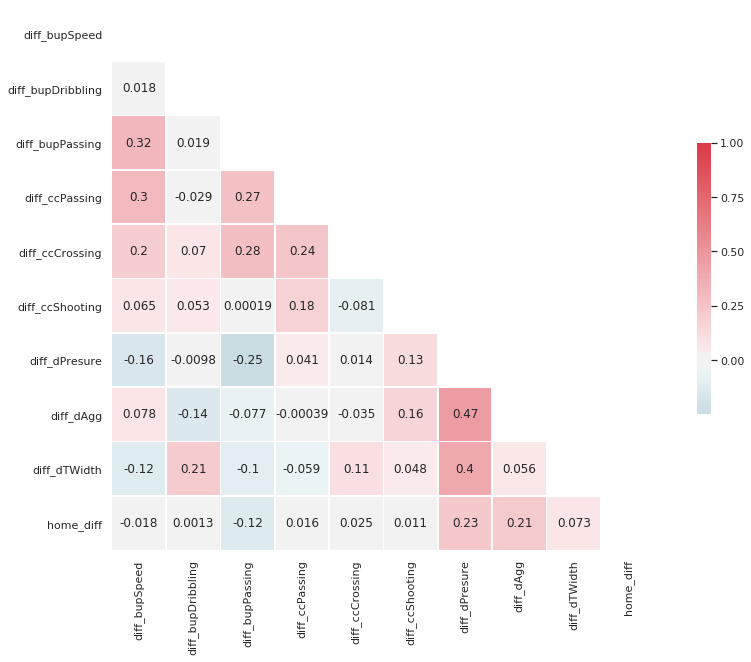

In [178]:
# Copied code from seaborn examples
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(reg_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(reg_corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show();

## Brief analysis

The difference between the defensive pressure and the defensive aggression have the highest degree association with goal difference with r-correlation of 0.23 and 0.21 respectively. Build up play passing and defense team width stats have some degree of association with goal difference as well but to a lesser extent with r-correlation of -0.12 and 0.073 respectively.

# Testing pipeline for regression

Will use different regression models to predict the goal difference of the match with the features being the difference between the 9 team home and away attributes.

## Obtaining baseline models

In [179]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

In [180]:
Xtrain,Xtest,ytrain,ytest = train_test_split(Xreg, y, test_size = 0.2, random_state=42)

In [181]:
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledRIDGE', Pipeline([('Scaler', StandardScaler()),('RIDGE', Ridge())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))

results = []
names = []
models = []
for name, model in pipelines:
    kfold = KFold(n_splits=20,shuffle=True, random_state=42)
    cv_results = cross_validate(model, Xtrain, ytrain, cv=kfold, scoring='neg_mean_squared_error',return_estimator=True,return_train_score=True)
    results.append(cv_results)
    names.append(name)
    models.append(model)
    msg = "%s: %f (%f)" % (name, cv_results['test_score'].mean(), cv_results['test_score'].std())
    print(msg)

ScaledLR: -3.159873 (0.519395)
ScaledLASSO: -3.395994 (0.630063)
ScaledRIDGE: -3.159856 (0.519410)
ScaledEN: -3.395994 (0.630063)
ScaledKNN: -3.532794 (0.496088)
ScaledCART: -6.349271 (0.903425)
ScaledGBM: -3.212862 (0.553876)


In [182]:
pipelines1 = []
pipelines1.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines1.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines1.append(('ScaledRIDGE', Pipeline([('Scaler', StandardScaler()),('RIDGE', Ridge())])))
pipelines1.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines1.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines1.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines1.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))

results1 = []
names1 = []
models1 = []
for name, model in pipelines1:
   
    kfold = KFold(n_splits=20,shuffle=True, random_state=42)
    cv_results1 = cross_validate(model, Xtrain, ytrain, cv=kfold, scoring='r2',return_estimator=True,return_train_score=True)
    results1.append(cv_results1)
    names1.append(name)
    models1.append(model)
    msg = "%s: %f (%f)" % (name, cv_results1['test_score'].mean(), cv_results1['test_score'].std())
    print(msg)

ScaledLR: 0.057697 (0.050270)
ScaledLASSO: -0.007734 (0.012019)
ScaledRIDGE: 0.057703 (0.050249)
ScaledEN: -0.007734 (0.012019)
ScaledKNN: -0.060710 (0.104359)
ScaledCART: -0.946693 (0.351465)
ScaledGBM: 0.042350 (0.053055)


In [183]:
coefs = np.zeros((20,len(results1[0]['estimator'][1][1].coef_)))
print(len(results1[0]['estimator'][1][1].coef_))
coefs.shape
for i in range(20):
    for j in range(len(results1[0]['estimator'][1][1].coef_)):
        coefs[i,j]= results1[0]['estimator'][i][1].coef_[j]
#result in results1[0]['estimator']:
#    coefs.append(result[1].coef_)

9


In [184]:
coef_mean = np.zeros(9)
coef_std = np.zeros(9)
for i in range(9):
    coef_mean[i] = np.mean(coefs[:,i])
    coef_std[i] = np.std(coefs[:,i])

In [185]:
coef_mean

array([ 0.0150321 ,  0.0355824 , -0.20028541,  0.07367048,  0.09425214,
       -0.05961914,  0.21098072,  0.30712769, -0.01329977])

In [186]:
coef_std

array([0.00901435, 0.01073093, 0.00802154, 0.01010489, 0.01121149,
       0.0074887 , 0.0117494 , 0.00949628, 0.01001805])

In [187]:
reg_features

['diff_bupSpeed',
 'diff_bupDribbling',
 'diff_bupPassing',
 'diff_ccPassing',
 'diff_ccCrossing',
 'diff_ccShooting',
 'diff_dPresure',
 'diff_dAgg',
 'diff_dTWidth']

In [188]:
reg_best_features = [reg_features[i] for i in (2,6,7)]
reg_best_features

['diff_bupPassing', 'diff_dPresure', 'diff_dAgg']

In [189]:
Xreg1 = df[reg_best_features]
y1 = df.home_diff

In [190]:
Xtrain1,Xtest1,ytrain1,ytest1 = train_test_split(Xreg1, y1, test_size = 0.2, random_state=42)

In [191]:
pipelines2 = []
pipelines2.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines2.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines2.append(('ScaledRIDGE', Pipeline([('Scaler', StandardScaler()),('RIDGE', Ridge())])))
pipelines2.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines2.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines2.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines2.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))

results2 = []
names2 = []
models2 = []
for name, model in pipelines2:
    kfold = KFold(n_splits=20,shuffle=True, random_state=42)
    cv_results = cross_validate(model, Xtrain1, ytrain1, cv=kfold, scoring='neg_mean_squared_error',return_estimator=True,return_train_score=True)
    results2.append(cv_results)
    names2.append(name)
    models2.append(model)
    msg = "%s: %f (%f)" % (name, cv_results['test_score'].mean(), cv_results['test_score'].std())
    print(msg)

ScaledLR: -3.160519 (0.521906)
ScaledLASSO: -3.395994 (0.630063)
ScaledRIDGE: -3.160515 (0.521925)
ScaledEN: -3.395994 (0.630063)
ScaledKNN: -3.836706 (0.597823)
ScaledCART: -6.428755 (0.769612)
ScaledGBM: -3.226848 (0.540341)


In [192]:
pipelines3 = []
pipelines3.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines3.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines3.append(('ScaledRIDGE', Pipeline([('Scaler', StandardScaler()),('RIDGE', Ridge())])))
pipelines3.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines3.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines3.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines3.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))

results3 = []
names3 = []
models3 = []
for name, model in pipelines3:
    kfold = KFold(n_splits=20,shuffle=True, random_state=42)
    cv_results = cross_validate(model, Xtrain1, ytrain1, cv=kfold, scoring='r2',return_estimator=True,return_train_score=True)
    results3.append(cv_results)
    names3.append(name)
    models3.append(model)
    msg = "%s: %f (%f)" % (name, cv_results['test_score'].mean(), cv_results['test_score'].std())
    print(msg)

ScaledLR: 0.057570 (0.046778)
ScaledLASSO: -0.007734 (0.012019)
ScaledRIDGE: 0.057573 (0.046762)
ScaledEN: -0.007734 (0.012019)
ScaledKNN: -0.149566 (0.117747)
ScaledCART: -0.967446 (0.346124)
ScaledGBM: 0.036913 (0.064647)


In [193]:
coefs3 = np.zeros((20,len(results3[0]['estimator'][1][1].coef_)))
print(len(results3[0]['estimator'][1][1].coef_))
coefs3.shape
for i in range(20):
    for j in range(len(results3[0]['estimator'][1][1].coef_)):
        coefs3[i,j]= results3[0]['estimator'][i][1].coef_[j]
#result in results1[0]['estimator']:
#    coefs.append(result[1].coef_)

3


In [194]:
coef_mean3 = np.zeros(3)
coef_std3 = np.zeros(3)
for i in range(3):
    coef_mean3[i] = np.mean(coefs3[:,i])
    coef_std3[i] = np.std(coefs3[:,i])

In [195]:
coef_mean3

array([-0.14721387,  0.22537378,  0.28905393])

In [196]:
coef_std3

array([0.00742678, 0.01027376, 0.00827566])

## Ridge Regression model improvement

In [197]:
from sklearn.model_selection import GridSearchCV

scaler = StandardScaler().fit(Xtrain1)
rescaledX = scaler.transform(Xtrain1)
param_grid = dict(alpha = np.array([0.01,0.05,0.1,0.5,1,5,10,50,100,500,1000,5000,10000]))
model = Ridge()
kfold = KFold(n_splits=20, random_state=21)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=kfold)
grid_result = grid.fit(rescaledX, ytrain1)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

/home/pug/data_science/DSIA/VE/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.057398 (0.042685) with: {'alpha': 0.01}
0.057398 (0.042685) with: {'alpha': 0.05}
0.057398 (0.042684) with: {'alpha': 0.1}
0.057399 (0.042680) with: {'alpha': 0.5}
0.057401 (0.042674) with: {'alpha': 1.0}
0.057410 (0.042630) with: {'alpha': 5.0}
0.057421 (0.042574) with: {'alpha': 10.0}
0.057497 (0.042139) with: {'alpha': 50.0}
0.057562 (0.041613) with: {'alpha': 100.0}
0.057160 (0.037999) with: {'alpha': 500.0}
0.055300 (0.034554) with: {'alpha': 1000.0}
0.035644 (0.022836) with: {'alpha': 5000.0}
0.021572 (0.018698) with: {'alpha': 10000.0}
Best: 0.057562 using {'alpha': 100.0}


In [198]:
from sklearn.metrics import r2_score

scaler = StandardScaler().fit(Xtrain1)
rescaled_X_train = scaler.transform(Xtrain1)
model = Ridge(alpha=100)
model.fit(rescaled_X_train, ytrain1)

# transform the validation dataset
rescaled_X_test = scaler.transform(Xtest1)
predictions = model.predict(rescaled_X_test)
print ('Test r2 score:',r2_score(ytest1, predictions))
print ('Train r2 score:',model.score(rescaled_X_train,ytrain1))

Test r2 score: 0.06263660877855604
Train r2 score: 0.07148336129702648


In [199]:
compare = pd.DataFrame({'Prediction': predictions, 'Test Data' : ytest1})
compare.head(20)

Prediction  Test Data
565     0.322378         -1
1220   -0.179640         -2
2797    1.528274          3
1578    0.996522         -1
2089    0.277389          0
2721    0.915853         -1
1831    0.408785         -1
1295    0.072708          1
2527    0.121672          0
1178    0.384993         -1
251    -0.202094          1
1084    0.711050         -2
203    -0.259739          0
402     0.048510         -1
2618    0.092504         -1
2700   -0.118545         -1
964     0.171793          0
2033   -0.036803         -3
2683    1.112279          6
1422    0.513550         -3

# Conclusion

The results were dissappointing to say the least. The best algorithm was ridge regression with $\alpha=100$, $r^2_{test}\approx 0.062$ and $r^2_{train}\approx 0.071$. This tells me that there is not enough correlation between the features to be good predictors of goal difference and hence, the features used in this project were overall not great predictors for the outcome of soccer games. A better approach would be to use the form of a team leading up to the game or recent match data. Also, to include which players were on the team or not and that would have perhaps made a significant difference to the prediction.